In [1]:
import numpy as np
import scipy
import scipy.optimize
from scipy.optimize import leastsq
from scipy.stats import norm
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import glob
from scipy.special import factorial
from scipy.stats import poisson
from scipy.interpolate import splrep, UnivariateSpline
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter
from mpl_toolkits.mplot3d import Axes3D

import time
plt.rcParams["figure.figsize"] = (3,3)

#nsec converted to microsec
tperiod = 54.79/1000
T = 3e7
T1 = 3e7
T2 = 5e7
N1 = 11
N2 = 13
N3 = 13
N4 = 11

print (time.ctime())

Tue Aug 11 08:48:41 2020


In [2]:
# read a data file, store all data in arrays

#file = "/home/imaginglab/Data/TPX3/CHIP0/Test/hiQEred_EntangledSource_10s_W0028_H11-191025-151713-1_cent.csv"
#file = "/home/andrei/Data/TPX3/CHIP0/Test/FirstIonTelegraf_100s_W0028_H11-200210-193057-1_cent.csv"
#\\Zhukaslaptoop\работа\2020\brookhaven sCMOS camera initial data\FastCameraData
file = "//Zhukaslaptoop/работа/2020/brookhaven sCMOS camera initial data/FastCameraData/fourions_diffcomp090_trigger100kHz_600s_W0028_H11-200211-203803-1_cent.csv"
#file = "/home/andrei/Data/TPX3/CHIP0/Test/ionszigzag_trigger100kHz_100s_W0028_H11-200211-190842-1_cent.csv"
#file = "/home/andrei/Data/TPX3/CHIP0/Test/fourions_diffcomp044_trigger100kHz_600s_W0028_H11-200211-201437-1_cent.csv"

print (file, time.ctime())

data=np.loadtxt(file, dtype= int, delimiter=",", usecols = (2,3,7,8))
#data=np.loadtxt(file, dtype= int, delimiter=",", usecols = (0,1,2,3,4))
#data=np.loadtxt(file, dtype= float, delimiter=",", usecols = 7)
#data=np.loadtxt(file, dtype= int, delimiter=",", usecols = (0,1,2,3,4,5,6,7))
#data=np.loadtxt(file, dtype= int, skiprows = 2, delimiter=",", usecols = (0,1,2,3,4,5,6))

#print data


//Zhukaslaptoop/работа/2020/brookhaven sCMOS camera initial data/FastCameraData/fourions_diffcomp090_trigger100kHz_600s_W0028_H11-200211-203803-1_cent.csv Tue Aug 11 08:48:41 2020


OSError: //Zhukaslaptoop/работа/2020/brookhaven sCMOS camera initial data/FastCameraData/fourions_diffcomp090_trigger100kHz_600s_W0028_H11-200211-203803-1_cent.csv not found.

In [265]:
print(len(data))
print(data[0])

6271726
[     91      96 1208235       7]


In [5]:
#tid = data
#tt  = data[:, 1]
y   = data[:, 0]
x   = data[:, 1]
#t   = data[:, 4]
#a   = data[:, 5]
#A   = data[:, 6]
tof = data[:,2]
n   = data[:, 3]
#yc  = data[:, 9]
#xc  = data[:, 10]
#tof_corr = data[:, 11]*1000

#fileCorrection = "/Users/andreinomerotski/Documents/Andrei/python/UWash/TOTcorrection.csv"
#correction = np.loadtxt(fileCorrection, unpack=True, delimiter=",")
#TOT_i  = [int(tot/25) for tot in a]
#t_corr = t/4096*25 + correction[1][TOT_i]*1000
#tof_corr = tof/4096*25 + correction[1][TOT_i]*1000

#for i in range(0,20):
#    print (i, x[i],y[i],t[i],a[i],A[i],n[i], tid[i], tt[i], tof[i]/4096*25)

for i in range(0,20):
       print (i, tof[i])
    
#print (len(t), time.ctime())

0 1208235
1 467968
2 1235286
3 622976
4 750379
5 239019
6 1173675
7 1268864
8 1612630
9 391552
10 603776
11 611456
12 1189675
13 757718
14 1124139
15 1592278
16 696022
17 282112
18 282368
19 478166


(0.0, 256.0)

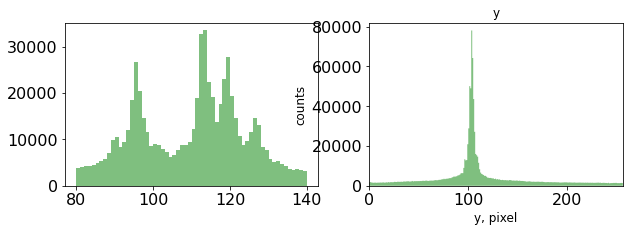

In [699]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 3))

ax0.hist(x, bins = 60, range = (80, 140), color = 'g', alpha=0.5, histtype = 'stepfilled')
plt.title("x", fontsize = 12) # change the title
plt.xlabel('x, pixel',fontsize = 12)
plt.ylabel('counts',fontsize = 12)

ax1.hist(y, bins = 256, range = (0, 256), color = 'g', alpha=0.5, histtype = 'stepfilled')
plt.title("y", fontsize = 12) # change the title
plt.xlabel('y, pixel',fontsize = 12)
plt.ylabel('counts',fontsize = 12)
plt.xlim(0, 256)

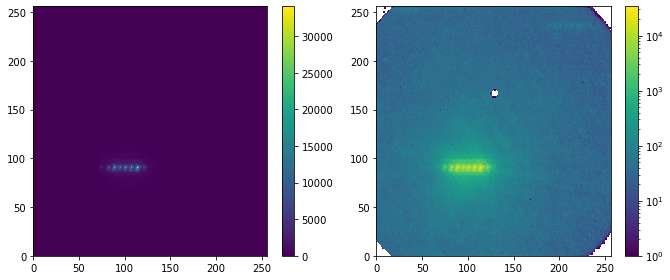

In [7]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(9.5, 4))

h = ax0.hist2d(x, y, bins = 256, range = [(0, 256), (0, 256)])
fig.colorbar(h[3], ax = ax0)

h = ax1.hist2d(x, y, bins = 256, range = [(0, 256), (0, 256)], norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax = ax1)
fig.tight_layout()
plt.show()


In [423]:
class Ion:
    def __init__(self, x0, y0, x1, y1, arrX, arrY, arrT, dT, N, n, debugPrinting=False):
        self.x0 = x0
        self.y0 = y0
        self.x1 = x1
        self.y1 = y1
        self.dT = dT
        self.N = N
        self.n = n
        self.debugPrinting = debugPrinting
        self.eventsForWindow = []
        
        assert len(arrX) == len(arrY) and len(arrY) == len(arrT)

        #self.FindBrightRangesPrecise(arrX, arrY, arrT)
        self.FindBrightWindowIntervals(arrX, arrY, arrT)

        #print("bright ranges, %s:" % len(self.brightRanges))
        sum = 0
        for i in self.brightRanges:
            sum += i[1] - i[0]
            if self.debugPrinting:
                print("%s - %s;" % (i[0], i[1]))

        #print("sum time when it was bright: %s sec" % (sum / 1e9))
        
        self.GetEventsInRIO(arrX, arrY, arrT)
        
    # an old function that find precise ranges when the ion was bright, 
    # does not work well with window based analysis.
    def FindBrightRangesPrecise(self, arrX, arrY, arrT):
        prevHits = []
        self.brightRanges = []
        currInterval = None

        for idx in range(len(arrX)):
            if self.IsInRegion(self.x0, self.y0, self.x1, self.y1, arrX[idx], arrY[idx]):
                t = arrT[idx]
                if self.debugPrinting:
                    print("check %s" % t)
                self.DeleteTooOldEvents(t, prevHits, currInterval)
                prevHits.append(t)
                if (len(prevHits) == self.N):
                    currInterval = [prevHits[0], prevHits[-1]]
                    if self.debugPrinting:
                        print("curr interval is started as %s-%s" % (prevHits[0], prevHits[-1]))

        self.DeleteTooOldEvents(1e14, prevHits, currInterval)

    # check if the event coordinates are in the region of interest
    def IsInRegion(self, x0, y0, x1, y1, x, y):
        return x0 <= x and x <= x1 and y0 <= y and y <= y1

    # delete events that are far than dT from the current event, update the bright intervals
    def DeleteTooOldEvents(self, t, prevHits, currInterval):
        while (len(prevHits) > 0 and (t - prevHits[0] > self.dT)):
            if (len(prevHits) == self.N):
                assert (currInterval != None)
                lastRange = None
                if len(self.brightRanges) > 0:
                    lastRange = self.brightRanges[-1]
                if (lastRange != None and lastRange[1] >= currInterval[0]):
                    self.brightRanges.pop()
                    currInterval[0] = lastRange[0]

                currInterval[1] = prevHits[-1]
                self.brightRanges.append(currInterval)
                if self.debugPrinting:
                    print("bright ranges append %s" % currInterval)

            oldElem = prevHits.pop(0)
            if self.debugPrinting:
                print("remove %s, length %s" % (oldElem, len(prevHits)))
                                                             
    def FindBrightWindowIntervals(self, arrX, arrY, arrT):        
        events = []
        for idx in range(len(arrX)):
            if self.IsInRegion(self.x0, self.y0, self.x1, self.y1, arrX[idx], arrY[idx]):
                events.append(arrT[idx])
                
        self.eventsForWindow = events
        
        print(len(events))
        
        self.brightRanges = []
        l = 0
        r = 0
        while l < len(events):
            intervalStart = self.GetIntervalBegin(events[l])
            r = l + 1
            while r < len(events) and events[r] - intervalStart <= self.dT:
                r += 1
            if r - l >= self.N:
                self.brightRanges.append([intervalStart, intervalStart + self.dT])
            l = r
        
        
    def GetIntervalBegin(self, x):
        res = self.dT * (int)(x / self.dT)
        return res

    # Returns if a moment lies in a bright interval.
    def IsBright(self, t):  # O(n), do O(ln(n))
        for i in self.brightRanges:
            if (i[0] <= t and t <= i[1]):
                return True
        return False

    # a helper funtion that returns bright or dark intervals for the ion.
    def GetRanges(self, tStart, tEnd, isBright):
        assert tStart <= self.brightRanges[0][0] <= tEnd

        if isBright:
            return self.brightRanges
        darkRanges = []

        # add the first interval before the first bright
        if tStart != self.brightRanges[0][0]:
            darkRanges.append([tStart, self.brightRanges[0][0]])

        # add all dark intervals between bright intervals
        for ind in range(len(self.brightRanges) - 1):
            prevEnd = self.brightRanges[ind][1]
            nextStart = self.brightRanges[ind + 1][0]
            darkRanges.append([prevEnd, nextStart])

        #add the last interval after the last bright
        if self.brightRanges[-1][1] != tEnd:
            darkRanges.append([self.brightRanges[-1][1], tEnd])

        return darkRanges

    @staticmethod
    def IncreaseIndex(idx):
        if (idx[1] == 0):
            return [idx[0], 1]
        return [idx[0] + 1, 0]

    @staticmethod
    def Intersect(ranges1, ranges2):
        intersections = []
        idx1 = [0,0]
        idx2 = [0,0]

        curInterStart = None

        while idx1[0] < len(ranges1) and idx2[0] < len(ranges2):
            nextX1 = ranges1[idx1[0]][idx1[1]]
            nextX2 = ranges2[idx2[0]][idx2[1]]
            if nextX1 < nextX2 or nextX1 == nextX2 and idx1[1] == 1:
                # is the second currently open?
                if idx2[1] == 1:
                    # the first is opening
                    if idx1[1] == 0:
                        # start a new intersection
                        curInterStart = nextX1

                    # the first is closing
                    else:
                        intersections.append([curInterStart, nextX1])
                        curInterStart = None

                idx1 = Ion.IncreaseIndex(idx1)
            else:
                # if the first currently open?
                if idx1[1] == 1:
                    # the second is opening
                    if idx2[1] == 0:
                        curInterStart = nextX2

                    # the second is closing
                    else:
                        intersections.append([curInterStart, nextX2])
                        curInterStart = None

                idx2 = Ion.IncreaseIndex(idx2)

        return intersections

    @staticmethod
    def IntersectIons(ion1, ion1Bright, ion2, ion2Bright, ion3 = None, ion3Bright = False):
        assert len(ion1.brightRanges) > 0 and len(ion2.brightRanges) > 0
        if ion3 is not None:
            assert len(ion3.brightRange) > 0

        tStart = min(ion1.brightRanges[0][0], ion2.brightRanges[0][0])
        tEnd = max(ion1.brightRanges[-1][1], ion2.brightRanges[-1][1])
        if ion3 is not None:
            tStart = min(tStart, ion3.brightRange[0][0])
            tEnd = max(tEnd, ion3.brightRange[-1][1])

        ranges1 = ion1.GetRanges(tStart, tEnd, ion1Bright)
        ranges2 = ion2.GetRanges(tStart, tEnd, ion2Bright)
        intersections = Ion.Intersect(ranges1, ranges2)

        if ion3 is not None:
            ranges3 = ion3.GetRanges(tStart, tEnd, ion3Bright)
            intersections = Ion.Intersect(intersections, ranges3)

        print("intersections, %s:" % len(intersections))
        sum = 0
        for i in intersections:
            sum += i[1] - i[0]
            # print("%s - %s;" % (i[0], i[1]))
        print("sum time of the intersection %s seconds" % (sum / 1e9))

        return intersections
    
    def GetCountsForEvents(self, x, y, events, intersections = None):
        xi = []
        yi = []
        eventsi = []
        for i in range(len(x)):
            if (self.x0 <= x[i] <= self.x1 and self.y0 <= y[i] <= self.y1):
                xi.append(x[i])
                yi.append(y[i])
                eventsi.append(events[i])
        
        eventsi1 = []
        if intersections is not None:
            for i in range(len(eventsi)):        
                for intersection in intersections:
                    if (intersection[0] <= eventsi[i] and eventsi[i] <= intersection[1]):
                        eventsi1.append(eventsi[i])
        else:
            eventsi1 = eventsi
        
        events = eventsi1
        
        #print("events")
        #print(events)
        
        res = []
        l = 0
        r = 0
        while l < len(events):
            intervalStart = self.GetIntervalBegin(events[l])
            r = l + 1
            while r < len(events) and events[r] - intervalStart <= self.dT:
                r += 1
            res.append(r - l)
            #print("append %s, interval begin %s, interval end %s, dT %s" % (r-l, intervalStart, events[r-1], self.dT))
            l = r
            
        sumTime = 0    
        if intersections is not None:
            for intersection in intersections:
                    sumTime += intersection[1] - intersection[0]
        else:
            sumTime = events[-1] - events[0]
        
        numberOfWindows = int(sumTime / self.dT)
        numberOfWindowsWithEvents = len(res)
        numberOfWindowsWithoutEvents = int(numberOfWindows - numberOfWindowsWithEvents)
        for i in range(numberOfWindowsWithoutEvents):
            res.append(0)
            
        print("number of windows %s, without events %s, with events %s" % 
              (numberOfWindows, numberOfWindowsWithoutEvents, numberOfWindowsWithEvents))
        
        return res
    
    def GetEventsInRIO (self, arrX, arrY, arrT):
        self.xs = []
        self.ys = []
        self.ts = []
        for i in range(len(arrX)-1):
            if ( self.x0 <= arrX[i] <= self.x1 and self.y0 <= arrY[i] <= self.y1 and 3<n[i]): 
                self.xs.append(arrX[i])
                self.ys.append(arrY[i])
                self.ts.append(arrT[i])
        print(len(self.xs),len(self.ys),len(self.ts))
        
        
    def PlotCountsInRIO_x (self):
        self.x2.sort()
        self.xss_1 = []
        self.count_1 = []
        curr = 0
        for idx, val in enumerate(x):
            if (idx != 0 and val == x[idx-1]):
                curr = curr + 1
            else:
                if (curr != 0):
                    self.xss_1.append(x[idx-1])
                    self.count_1.append(curr)
                curr = 1
        if (curr != 0):
            self.xss_1.append(x[-1])
            self.count_1.append(curr)
        print(self.count_1)

        plt.xlim(self.x0,self.x1)
        plt.ylim(0,20)
        plt.xlabel('position')
        plt.ylabel('counts')
        plt.plot(self.xss_1, self.count_1)
        
    def PlotCountsInRIO_y (self):
        self.y2.sort()
        self.yss_2 = []
        self.count_2 = []
        curr = 0
        for idx, val in enumerate(y):
            if (idx != 0 and val == y[idx-1]):
                curr = curr + 1
            else:
                if (curr != 0):
                    self.yss_2.append(y[idx-1])
                    self.count_2.append(curr)
                curr = 1
        if (curr != 0):
            self.yss_2.append(y[-1])
            self.count_2.append(curr)
        print(self.count_2)

        plt.xlim(self.y0,self.y1)
        plt.ylim(0,20)
        plt.xlabel('position')
        plt.ylabel('counts')
        plt.plot(self.yss_2, self.count_2)
                
    def PlotCountsInRIO (self):
        self.xs.sort()
        self.xss = []
        self.count = []
        curr = 0
        for idx, val in enumerate(self.xs):
            if (idx != 0 and val == self.xs[idx-1]):
                curr = curr + 1
            else:
                if (curr != 0):
                    self.xss.append(self.xs[idx-1])
                    self.count.append(curr)
                curr = 1
        if (curr != 0):
            self.xss.append(self.xs[-1])
            self.count.append(curr)


        plt.xlim(self.x0,self.x1)
        plt.xlabel('position')
        plt.ylabel('counts')
        plt.plot(self.xss, self.count)
        
    def ReturnHistogramdT(self, bins):
        self.count_h = self.GetCountsForEvents(self.xs, self.ys, self.ts)
        
        print("count h len %s" % len(self.count_h))    
        plt.hist(self.count_h, bins = bins, alpha=1, histtype= 'step', ec= 'blue', stacked=True) 
        plt.xlabel('Number of photons')
        plt.ylabel('Number of events')
        plt.title('Integration time of 10 μsec')
        plt.show()
        
    def FittingPoisson (self, bins, guess_lambd):
    # the bins should be of integer width, because poisson is an integer distribution!!! that's why it didnt' work before
  
        entries, bin_edges, patches = plt.hist(self.count_h, bins=bins, density=True, label='Data')

        #for idx in range(bins - 1):
            #print(bin_edges[idx])


        # calculate bin centres
        bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        
        #print(len(bin_edges))
        #print(len(bin_middles))

        guess_lamb = guess_lambd
        guess  = np.array([guess_lamb])

        def fit_function(k, lamb):
            return np.exp(-lamb)*np.power(lamb,k)/factorial(k)
        #poisson.pmf(k, lamb)

        #bin_edges = [1,2,3]
        #print("bin edges:")
        #print(bin_edges)
        # fit with curve_fit
        popt1, cov1 = scipy.optimize.curve_fit(fit_function, bin_edges[0:-1], entries,p0=guess, maxfev = 50000)

        print ('lambda =', popt1[0])
        p_sigma = np.sqrt(np.diag(cov1))
        print('std error =',p_sigma)

        # plot fit
        data_fit = fit_function(bin_edges, *popt1)
        
        data_fit = data_fit[0:-1]
        
        #fig = plt.figure(figsize=(5,5))
        #font = {'size'   : 16}
        #plt.rc('font', **font)
        #ax = fig.add_subplot(111)
        ##h = ax.plot(bin_edges[0:-1], data_fit,color='black',label='Fitting' )
        #spl = UnivariateSpline(bin_middles, data_fit, k = 1)
        ##x_spl = np.linspace(-3, 3, 50)
        #h = ax.plot(bin_middles, spl, 'r--', linewidth=2, label='Fitting')
        #entries, bin_edges, patches = plt.hist(self.count_h, bins = bins, density=True, alpha=0.3, histtype= 'bar', ec= 'black', label='Data', color='b', stacked=True);
        #plt.xlabel('Number of photons',fontsize=16)
        #plt.ylabel('Event probability',fontsize=16)
        ##plt.title('50 μsec: ion')
        #plt.legend(loc='upper right')
        #plt.show()
        
        fig = plt.figure(figsize=(5,5))
        font = {'size'   : 16}
        plt.rc('font', **font)
        ax = fig.add_subplot(111)

        entries, bin_edges, patches = plt.hist(self.count_h, bins = bins, density=True, alpha=0.3, histtype= 'bar', ec= 'black', label='Data', color='b', stacked=True);
        plt.xlabel('Number of photons',fontsize=16)
        plt.ylabel('Event probability',fontsize=16)
        
        
        t = np.arange(0, 90, 0.1)
        d = np.exp(-popt1[0])*np.power(popt1[0], t)/factorial(t)

        plt.plot(t+0.5, d,'b--', label='Fit')

      
        #plt.title('50 μsec: ion')
        plt.legend(loc='upper right')
        
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1])
        
        plt.xlim((0,90))
        plt.show()

        return self.count_h, bins, t, d
    
    def FittingPoisson (self, bins, x):
    # the bins should be of integer width, because poisson is an integer distribution!!! that's why it didnt' work before
  
        entries, bin_edges, patches = plt.hist(x, bins=bins, density=True, label='Data')

        bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])

        guess_lamb = np.amax(x)
        guess  = np.array([guess_lamb])

        def fit_function(k, lamb):
            return np.exp(-lamb)*np.power(lamb,k)/factorial(k)
        #poisson.pmf(k, lamb)

        #bin_edges = [1,2,3]
        #print("bin edges:")
        #print(bin_edges)
        # fit with curve_fit
        popt1, cov1 = scipy.optimize.curve_fit(fit_function, bin_edges[0:-1], entries,p0=guess, maxfev = 50000)

        print ('lambda =', popt1[0])
        p_sigma = np.sqrt(np.diag(cov1))
        print('std error =',p_sigma)

        # plot fit
        data_fit = fit_function(bin_edges, *popt1)
        
        data_fit = data_fit[0:-1]
        
        #fig = plt.figure(figsize=(5,5))
        #font = {'size'   : 16}
        #plt.rc('font', **font)
        #ax = fig.add_subplot(111)
        ##h = ax.plot(bin_edges[0:-1], data_fit,color='black',label='Fitting' )
        #spl = UnivariateSpline(bin_middles, data_fit, k = 1)
        ##x_spl = np.linspace(-3, 3, 50)
        #h = ax.plot(bin_middles, spl, 'r--', linewidth=2, label='Fitting')
        #entries, bin_edges, patches = plt.hist(self.count_h, bins = bins, density=True, alpha=0.3, histtype= 'bar', ec= 'black', label='Data', color='b', stacked=True);
        #plt.xlabel('Number of photons',fontsize=16)
        #plt.ylabel('Event probability',fontsize=16)
        ##plt.title('50 μsec: ion')
        #plt.legend(loc='upper right')
        #plt.show()
        
        fig = plt.figure(figsize=(5,5))
        font = {'size'   : 16}
        plt.rc('font', **font)
        ax = fig.add_subplot(111)

        entries, bin_edges, patches = plt.hist(x, bins = bins, density=True, alpha=0.3, histtype= 'bar', ec= 'black', label='Data', color='b', stacked=True);
        plt.xlabel('Number of photons',fontsize=16)
        plt.ylabel('Event probability',fontsize=16)
        
        
        t = np.arange(self.x0, self.x1, 0.1)
        d = np.exp(-popt1[0])*np.power(popt1[0], t)/factorial(t)

        plt.plot(t+0.5, d,'b--', label='Fit')

      
        #plt.title('50 μsec: ion')
        plt.legend(loc='upper right')
        
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1])
        
        plt.xlim((0,90))
        plt.show()

        return bins, t, d
    
    def timefold (self, d, t0): 
        
        self.tfold1 = []

        for i in range(len(self.ts)):
            self.tfold1.append(ionz.ts[i]%tperiod*4096./25.)

        #print(len(tfold1))
        
        self.x2 = []
        self.y2 = []

        for i in range(len(self.tfold1)):
            if (t0 <= self.tfold1[i] <= t0 + d) :
        #        tof2.append(tof[i])
                self.x2.append(self.xs[i])
                self.y2.append(self.ys[i])
    
        
    def Gaussian_fit_x (self, nbins, amp, xm, sigm):
        
        from scipy.optimize import curve_fit

        def gaussian(x, xm, sigma, A, c): return np.absolute(A)*np.exp(-np.power((x-xm)/sigma,2)/2) + c

        xmin  = self.x0
        xmax  = self.x1
        #nbins = 90
        #normalization = ((xmax-xmin)/nbins*len(deltaTc))
        normalization = (xmax-xmin)/nbins

        def guess_f ():
            count_max = np.amax(self.count_1)
            idx1 = 0
            for idx, val in enumerate(self.count_1):
                if (self.count_1[idx] == count_max):
                    idx1 = idx
                    print(idx1,self.count_1[idx1])

            return (idx1)

        #guess_meanx = ionz.xss_1[guess_f()]
        guess_meanx = xm
        guess_sigma = sigm
        #guess_amp = np.amax(ionz.count_1)
        guess_amp = amp
        guess_c = 1
        #guess_c = np.amin(count1)
        guess  = np.array([guess_meanx,guess_sigma,guess_amp,guess_c])

        #hist, bin_edges = np.histogram(ToFmus[indarr], range=(), bins=nbins, density=True)
        hist, bin_edges = np.histogram(self.x2, range=(xmin,xmax), bins=nbins, density=True)
        bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
        
        popt, pcov = curve_fit(gaussian, bin_centres, hist, p0=guess, maxfev = 50000)
        
        print ('ym =', popt[0])
        p_sigma = np.sqrt(np.diag(pcov))
        print('std error =',p_sigma)

        hist_fit = gaussian(bin_centres, *popt)

        plt.figure(figsize=(8, 4))
        plt.plot(bin_centres, hist, 'r--')
        plt.plot(bin_centres, hist_fit)
        plt.axis([xmin, xmax, 0, 1])
        plt.xlabel('Coordinate - x (pixels)')
        plt.ylabel('Probability')
        plt.show()

        print ('xm =', popt[0], 'sigma =', popt[1], 'amplitude = ', popt[2], 'shift = ', popt[3])
        
    def Gaussian_fit_y (self, nbins, amp, ym, sigm):
        
        from scipy.optimize import curve_fit

        def gaussian(y, ym, sigma, A, c): return np.absolute(A)*np.exp(-np.power((y-ym)/sigma,2)/2) + c

        ymin  = self.y0
        ymax  = self.y1
        #nbins = 90
        #normalization = ((xmax-xmin)/nbins*len(deltaTc))
        normalization = (ymax-ymin)/nbins

        def guess_f ():
            count_max = np.amax(self.count_2)
            idy1 = 0
            for idx, val in enumerate(self.count_2):
                if (self.count_2[idx] == count_max):
                    idy1 = idx
                    print(idy1,self.count_2[idy1])

            return (idy1)

        #guess_meanx = ionz.xss_1[guess_f()]
        guess_meany = ym
        guess_sigma = sigm
        #guess_amp = np.amax(ionz.count_1)
        guess_amp = amp
        guess_c = 1
        #guess_c = np.amin(count1)
        guess  = np.array([guess_meany,guess_sigma,guess_amp,guess_c])

        #hist, bin_edges = np.histogram(ToFmus[indarr], range=(), bins=nbins, density=True)
        hist, bin_edges = np.histogram(self.y2, range=(ymin,ymax), bins=nbins, density=True)
        bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

        popt, pcov = curve_fit(gaussian, bin_centres, hist, p0=guess, maxfev = 50000)
        
        print ('ym =', popt[0])
        p_sigma = np.sqrt(np.diag(pcov))
        print('std error =',p_sigma)

        hist_fit = gaussian(bin_centres, *popt)

        plt.figure(figsize=(8, 4))
        plt.plot(bin_centres, hist, 'r--')
        plt.plot(bin_centres, hist_fit)
        plt.axis([ymin, ymax, 0, 1])
        plt.xlabel('Coordinate - y (pixels)')
        plt.ylabel('Probability')
        plt.show()

        print ('ym =', popt[0], 'sigma =', popt[1], 'amplitude = ', popt[2], 'shift = ', popt[3])

    brightRanges = []

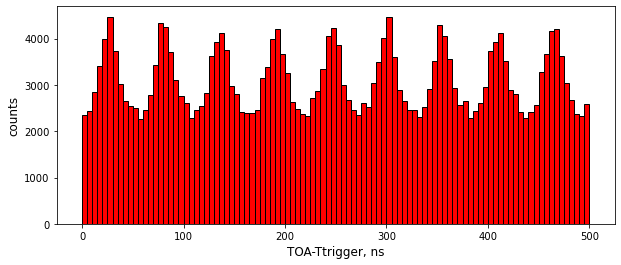

In [9]:
fig, ax0 = plt.subplots(ncols=1, figsize=(10, 4))
plt.hist(tof/4096.*25., bins = 100, range = (0, 500), color = 'r', ec = 'k')
plt.xlabel('TOA-Ttrigger, ns',fontsize = 12)
plt.ylabel('counts',fontsize = 12)
plt.show()


In [11]:
ion2 = Ion(86, 103, 93, 106, x, y, tof, T, N2, n)

362782
329702 329702 329702


In [32]:
ion2.eventsForWindow

[1173675,
 957952,
 217259,
 576128,
 189739,
 801451,
 1490432,
 316587,
 511915,
 806742,
 744918,
 1012523,
 6912,
 486016,
 1309142,
 328918,
 681387,
 1208235,
 1018411,
 1598934,
 1277227,
 1610283,
 822059,
 1281280,
 1384704,
 1343958,
 539264,
 908758,
 261846,
 547755,
 1635840,
 881366,
 1536640,
 1062912,
 1410176,
 701611,
 547712,
 598443,
 869888,
 1277184,
 628822,
 416640,
 977494,
 1012139,
 745088,
 1256534,
 126806,
 1569835,
 937856,
 864512,
 217984,
 312192,
 688043,
 906198,
 500438,
 1098070,
 581120,
 1156096,
 817920,
 1275094,
 1375915,
 1050667,
 402432,
 1494443,
 1582720,
 1285120,
 1053014,
 157654,
 1579520,
 1492950,
 594006,
 166528,
 322560,
 554454,
 1634816,
 634795,
 427222,
 466646,
 1154816,
 1231104,
 736214,
 547542,
 201088,
 355115,
 279595,
 1263232,
 615083,
 879403,
 1624662,
 1079808,
 1515350,
 1254144,
 457558,
 1054123,
 411478,
 749056,
 1085355,
 1220054,
 619008,
 890880,
 1202390,
 158848,
 963883,
 1614976,
 853718,
 528598,
 292

In [78]:
tfold = []

for i in range(len(ion2.ts)):
    tfold.append(ion2.ts[i]%tperiod)
    
print(len(tfold))

362781


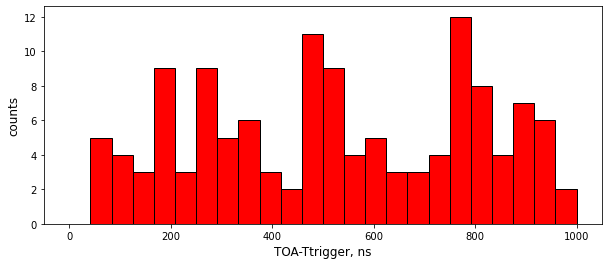

In [74]:
fig, ax0 = plt.subplots(ncols=1, figsize=(10, 4))
plt.hist(ion2.eventsForWindow, bins = 24, range = (0, 1000), color = 'r', ec = 'k')
plt.xlabel('TOA-Ttrigger, ns',fontsize = 12)
plt.ylabel('counts',fontsize = 12)
plt.show()

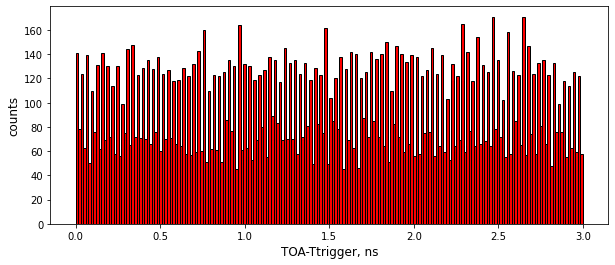

In [83]:
fig, ax0 = plt.subplots(ncols=1, figsize=(10, 4))
plt.hist(tfold, bins = 200, range = (0, 3), color = 'r', ec = 'k')
plt.xlabel('TOA-Ttrigger, ns',fontsize = 12)
plt.ylabel('counts',fontsize = 12)
plt.show()

362781
362781


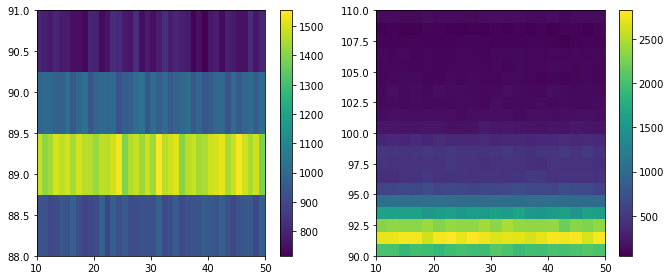

In [88]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(9.5, 4))

print(len(ion2.ts))
print(len(ion2.xs))

h = ax0.hist2d(tfold, ion2.xs, bins = [40,4], range = [(10, 50),(88,91)])
fig.colorbar(h[3], ax = ax0)

h = ax1.hist2d(tfold, ion2.ys, bins = 20, range = [(10, 50),(90,110)])
fig.colorbar(h[3], ax = ax1)
fig.tight_layout()
plt.show()

In [190]:
file = "D:/Liudmila/data_BNL_feb/centr/ionszigzag_trigger100kHz_100s_W0028_H11-200211-190842-1_cent.csv"

print (file, time.ctime())

data=np.loadtxt(file, dtype= float, delimiter=",", usecols = (8,9,10,11))


D:/Liudmila/data_BNL_feb/centr/ionszigzag_trigger100kHz_100s_W0028_H11-200211-190842-1_cent.csv Wed Jul  1 18:35:06 2020


In [191]:
#tid = data
#tt  = data[:, 1]
y1   = data[:, 1]
x1   = data[:, 2]
#t   = data[:, 4]
#a   = data[:, 5]
#A   = data[:, 6]
tof1 = data[:,3]
n   = data[:, 0]
#yc  = data[:, 9]
#xc  = data[:, 10]
#tof_corr = data[:, 11]*1000

#fileCorrection = "/Users/andreinomerotski/Documents/Andrei/python/UWash/TOTcorrection.csv"
#correction = np.loadtxt(fileCorrection, unpack=True, delimiter=",")
#TOT_i  = [int(tot/25) for tot in a]
#t_corr = t/4096*25 + correction[1][TOT_i]*1000
#tof_corr = tof/4096*25 + correction[1][TOT_i]*1000

#for i in range(0,20):
#    print (i, x[i],y[i],t[i],a[i],A[i],n[i], tid[i], tt[i], tof[i]/4096*25)

for i in range(0,20):
       print (i, tof[i])
    
#print (len(t), time.ctime())

0 1208235
1 467968
2 1235286
3 622976
4 750379
5 239019
6 1173675
7 1268864
8 1612630
9 391552
10 603776
11 611456
12 1189675
13 757718
14 1124139
15 1592278
16 696022
17 282112
18 282368
19 478166


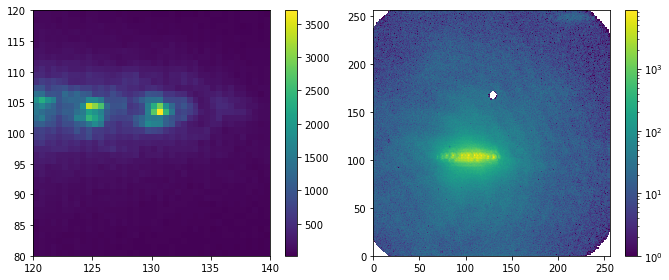

In [192]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(9.5, 4))

h = ax0.hist2d(x1, y1, bins = 40, range = [(120,140), (80,120)])
fig.colorbar(h[3], ax = ax0)

h = ax1.hist2d(x1, y1, bins = 256, range = [(0, 256), (0, 256)], norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax = ax1)
fig.tight_layout()
plt.show()


(0.0, 256.0)

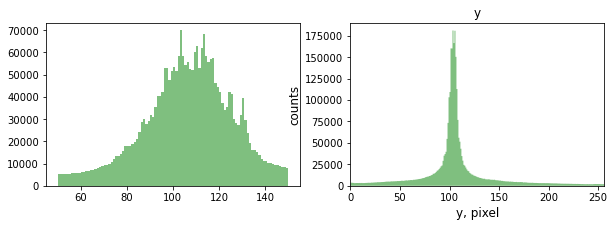

In [193]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 3))

ax0.hist(x1, bins = 100, range = (50, 150), color = 'g', alpha=0.5, histtype = 'stepfilled')
plt.title("x", fontsize = 12) # change the title
plt.xlabel('x, pixel',fontsize = 12)
plt.ylabel('counts',fontsize = 12)

ax1.hist(y1, bins = 256, range = (0, 256), color = 'g', alpha=0.5, histtype = 'stepfilled')
plt.title("y", fontsize = 12) # change the title
plt.xlabel('y, pixel',fontsize = 12)
plt.ylabel('counts',fontsize = 12)
plt.xlim(0, 256)

In [431]:
ionz = Ion(128, 102, 132, 106, x1, y1, tof1, T, N2, n)

44328
40216 40216 40216


In [475]:
#the first argument is interval, the second - chosen time (start)
ionz.timefold(0.5, 7.5)

ym = 130.59022322267273
std error = [0.07802577 0.12251385 0.03370353 0.02847363]


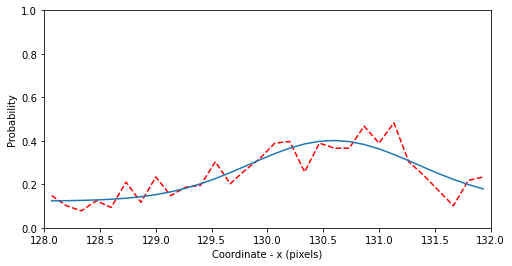

xm = 130.59022322267273 sigma = 0.7505093672238194 amplitude =  0.27855730316418753 shift =  0.12295639829640415


In [477]:
ionz.Gaussian_fit_x(30,0.5,130,0.5)

In [391]:
#the first argument is interval, the second - chosen time (start)
ionz.timefold(0.5, 5)

ym = 103.57597430533592
std error = [0.02772173 0.03352675 0.01543803 0.00800793]


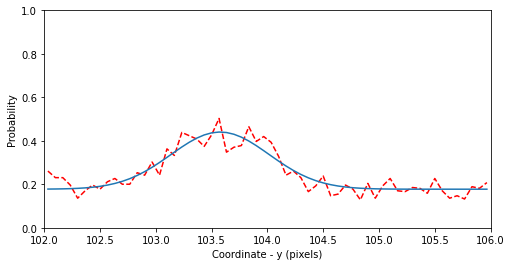

ym = 103.57597430533592 sigma = 0.4398236981887714 amplitude =  0.2629188506051354 shift =  0.17754680539800083


In [393]:
ionz.Gaussian_fit_y(60,0.5,104,0.5)

Text(0, 0.5, 'counts')

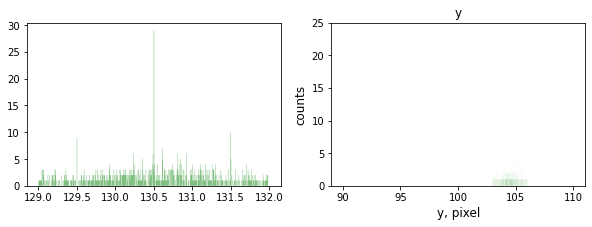

In [175]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 3))
#bins = 12381

ax0.hist(ionz.x2, bins = 500, range = (129, 132), color = 'g', alpha=0.5, histtype = 'stepfilled')
plt.title("x", fontsize = 12) # change the title
plt.xlabel('x, pixel',fontsize = 12)
plt.ylabel('counts',fontsize = 12)
plt.ylim(0, 25)

ax1.hist(ionz.y2, bins = 12381, range = (90, 110), color = 'g', alpha=0.5, histtype = 'stepfilled')
plt.title("y", fontsize = 12) # change the title
plt.xlabel('y, pixel',fontsize = 12)
plt.ylabel('counts',fontsize = 12)
#plt.xlim(0, 256)

36130
36130
54935


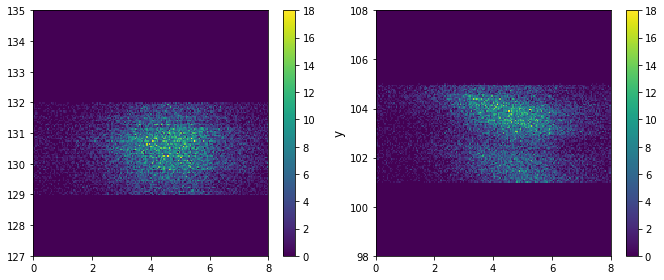

In [287]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(9.5, 4))

print(len(ionz.ts))
print(len(ionz.xs))
print(len(tfold1))

h = ax0.hist2d(ionz.tfold1, ionz.xs, bins = 180, range = [(0, 8),(127,135)])
fig.colorbar(h[3], ax = ax0)
plt.ylabel('x-trap axis',fontsize = 12)

h = ax1.hist2d(ionz.tfold1, ionz.ys, bins = 180, range = [(0, 8),(98,108)])
fig.colorbar(h[3], ax = ax1)
fig.tight_layout()
plt.ylabel('y',fontsize = 12)
plt.show()

In [180]:
file = "D:\Liudmila\data_BNL_feb\centr/Trigger Data Pandas_linear_chain_mod.csv"

print (file, time.ctime())

data=np.loadtxt(file, dtype= float, delimiter=",", usecols = (8,9,10,11,12))

D:\Liudmila\data_BNL_feb\centr/Trigger Data Pandas_linear_chain_mod.csv Wed Jul  8 17:25:57 2020


In [3]:
import pandas as pd
full_data_table = pd.read_csv('Trigger Data Pandas')
#full_data_table = pd.read_csv('Trigger Data Pandas_linear_chain_mod')
data = full_data_table.query("`cluster size` > 4")

n   = data['cluster size']
n = n.values.tolist()
y   = data['yc']
y = y.values.tolist()
x   = data['xc']
x = x.values.tolist()
tof = data['tof']
tof = tof.values.tolist()
fold = data['tfold']
fold = fold.values.tolist()

#fileCorrection = "/Users/andreinomerotski/Documents/Andrei/python/UWash/TOTcorrection.csv"
#correction = np.loadtxt(fileCorrection, unpack=True, delimiter=",")
#TOT_i  = [int(tot/25) for tot in a]
#t_corr = t/4096*25 + correction[1][TOT_i]*1000
#tof_corr = tof/4096*25 + correction[1][TOT_i]*1000

#for i in range(0,20):
#    print (i, x[i],y[i],t[i],a[i],A[i],n[i], tid[i], tt[i], tof[i]/4096*25)

for i in range(0,20):
       print (i, fold[i])
    
print (len(fold), len(x),len(y))

0 27.809243171874925
1 9.381129999999658
2 27.108487171874714
3 34.19775434374971
4 35.015963171874645
5 28.49579817187466
6 4.795846999999661
7 16.491928343749617
8 19.529857999999923
9 18.2661033437497
10 44.86508934374972
11 22.5452081718746
12 21.33261334374979
13 8.467753343749543
14 24.975939343749882
15 13.644998999999835
16 19.76353699999988
17 6.182876999999942
18 35.83417199999958
19 23.429147999999515
1655554 1655554 1655554


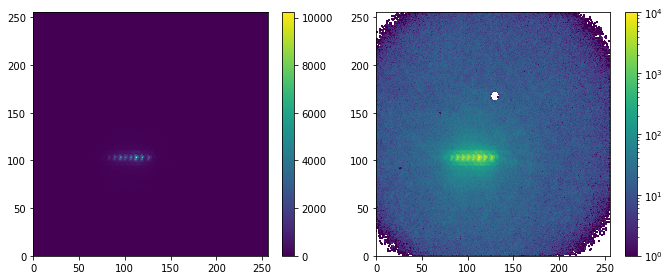

In [4]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(9.5, 4))

h = ax0.hist2d(x, y, bins = 256, range = [(0, 256), (0, 256)])
fig.colorbar(h[3], ax = ax0)

h = ax1.hist2d(x, y, bins = 256, range = [(0, 256), (0, 256)], norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax = ax1)
fig.tight_layout()
plt.show()


(0.0, 256.0)

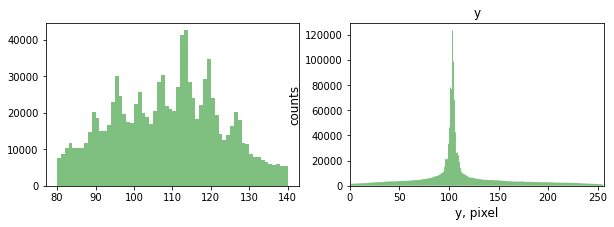

In [5]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 3))

ax0.hist(x, bins = 60, range = (80, 140), color = 'g', alpha=0.5, histtype = 'stepfilled')
plt.title("x", fontsize = 12) # change the title
plt.xlabel('x, pixel',fontsize = 12)
plt.ylabel('counts',fontsize = 12)

ax1.hist(y, bins = 256, range = (0, 256), color = 'g', alpha=0.5, histtype = 'stepfilled')
plt.title("y", fontsize = 12) # change the title
plt.xlabel('y, pixel',fontsize = 12)
plt.ylabel('counts',fontsize = 12)
plt.xlim(0, 256)

In [6]:
class Ion:
    def __init__(self, x0, y0, x1, y1, arrX, arrY, arrT, dT, N, n, debugPrinting=False):
        self.x0 = x0
        self.y0 = y0
        self.x1 = x1
        self.y1 = y1
        self.dT = dT
        self.N = N
        self.n = n
        self.debugPrinting = debugPrinting
        self.eventsForWindow = []
        
        assert len(arrX) == len(arrY) and len(arrY) == len(arrT)

        #self.FindBrightRangesPrecise(arrX, arrY, arrT)
        self.FindBrightWindowIntervals(arrX, arrY, arrT)

        #print("bright ranges, %s:" % len(self.brightRanges))
        sum = 0
        for i in self.brightRanges:
            sum += i[1] - i[0]
            if self.debugPrinting:
                print("%s - %s;" % (i[0], i[1]))

        #print("sum time when it was bright: %s sec" % (sum / 1e9))
        
        self.GetEventsInRIO(arrX, arrY, arrT)
        
    # an old function that find precise ranges when the ion was bright, 
    # does not work well with integration time based analysis.
    def FindBrightRangesPrecise(self, arrX, arrY, arrT):
        prevHits = []
        self.brightRanges = []
        currInterval = None

        for idx in range(len(arrX)):
            if self.IsInRegion(self.x0, self.y0, self.x1, self.y1, arrX[idx], arrY[idx]):
                t = arrT[idx]
                if self.debugPrinting:
                    print("check %s" % t)
                self.DeleteTooOldEvents(t, prevHits, currInterval)
                prevHits.append(t)
                if (len(prevHits) == self.N):
                    currInterval = [prevHits[0], prevHits[-1]]
                    if self.debugPrinting:
                        print("curr interval is started as %s-%s" % (prevHits[0], prevHits[-1]))

        self.DeleteTooOldEvents(1e14, prevHits, currInterval)

    # check if the event coordinates are in the region of interest
    def IsInRegion(self, x0, y0, x1, y1, x, y):
        return x0 <= x and x <= x1 and y0 <= y and y <= y1

    # delete events that are far than dT from the current event, update the bright intervals
    def DeleteTooOldEvents(self, t, prevHits, currInterval):
        while (len(prevHits) > 0 and (t - prevHits[0] > self.dT)):
            if (len(prevHits) == self.N):
                assert (currInterval != None)
                lastRange = None
                if len(self.brightRanges) > 0:
                    lastRange = self.brightRanges[-1]
                if (lastRange != None and lastRange[1] >= currInterval[0]):
                    self.brightRanges.pop()
                    currInterval[0] = lastRange[0]

                currInterval[1] = prevHits[-1]
                self.brightRanges.append(currInterval)
                if self.debugPrinting:
                    print("bright ranges append %s" % currInterval)

            oldElem = prevHits.pop(0)
            if self.debugPrinting:
                print("remove %s, length %s" % (oldElem, len(prevHits)))
                                                             
    def FindBrightWindowIntervals(self, arrX, arrY, arrT):        
        events = []
        for idx in range(len(arrX)):
            if self.IsInRegion(self.x0, self.y0, self.x1, self.y1, arrX[idx], arrY[idx]):
                events.append(arrT[idx])
                
        self.eventsForWindow = events
        
        print(len(events))
        
        self.brightRanges = []
        l = 0
        r = 0
        while l < len(events):
            intervalStart = self.GetIntervalBegin(events[l])
            r = l + 1
            while r < len(events) and events[r] - intervalStart <= self.dT:
                r += 1
            if r - l >= self.N:
                self.brightRanges.append([intervalStart, intervalStart + self.dT])
            l = r
        
        
    def GetIntervalBegin(self, x):
        res = self.dT * (int)(x / self.dT)
        return res

    # Returns if a moment lies in a bright interval.
    def IsBright(self, t):  # O(n), do O(ln(n))
        for i in self.brightRanges:
            if (i[0] <= t and t <= i[1]):
                return True
        return False

    # a helper funtion that returns bright or dark intervals for the ion.
    def GetRanges(self, tStart, tEnd, isBright):
        assert tStart <= self.brightRanges[0][0] <= tEnd

        if isBright:
            return self.brightRanges
        darkRanges = []

        # add the first interval before the first bright
        if tStart != self.brightRanges[0][0]:
            darkRanges.append([tStart, self.brightRanges[0][0]])

        # add all dark intervals between bright intervals
        for ind in range(len(self.brightRanges) - 1):
            prevEnd = self.brightRanges[ind][1]
            nextStart = self.brightRanges[ind + 1][0]
            darkRanges.append([prevEnd, nextStart])

        #add the last interval after the last bright
        if self.brightRanges[-1][1] != tEnd:
            darkRanges.append([self.brightRanges[-1][1], tEnd])

        return darkRanges

    @staticmethod
    def IncreaseIndex(idx):
        if (idx[1] == 0):
            return [idx[0], 1]
        return [idx[0] + 1, 0]

    @staticmethod
    def Intersect(ranges1, ranges2):
        intersections = []
        idx1 = [0,0]
        idx2 = [0,0]

        curInterStart = None

        while idx1[0] < len(ranges1) and idx2[0] < len(ranges2):
            nextX1 = ranges1[idx1[0]][idx1[1]]
            nextX2 = ranges2[idx2[0]][idx2[1]]
            if nextX1 < nextX2 or nextX1 == nextX2 and idx1[1] == 1:
                # is the second currently open?
                if idx2[1] == 1:
                    # the first is opening
                    if idx1[1] == 0:
                        # start a new intersection
                        curInterStart = nextX1

                    # the first is closing
                    else:
                        intersections.append([curInterStart, nextX1])
                        curInterStart = None

                idx1 = Ion.IncreaseIndex(idx1)
            else:
                # if the first currently open?
                if idx1[1] == 1:
                    # the second is opening
                    if idx2[1] == 0:
                        curInterStart = nextX2

                    # the second is closing
                    else:
                        intersections.append([curInterStart, nextX2])
                        curInterStart = None

                idx2 = Ion.IncreaseIndex(idx2)

        return intersections

    @staticmethod
    def IntersectIons(ion1, ion1Bright, ion2, ion2Bright, ion3 = None, ion3Bright = False):
        assert len(ion1.brightRanges) > 0 and len(ion2.brightRanges) > 0
        if ion3 is not None:
            assert len(ion3.brightRange) > 0

        tStart = min(ion1.brightRanges[0][0], ion2.brightRanges[0][0])
        tEnd = max(ion1.brightRanges[-1][1], ion2.brightRanges[-1][1])
        if ion3 is not None:
            tStart = min(tStart, ion3.brightRange[0][0])
            tEnd = max(tEnd, ion3.brightRange[-1][1])

        ranges1 = ion1.GetRanges(tStart, tEnd, ion1Bright)
        ranges2 = ion2.GetRanges(tStart, tEnd, ion2Bright)
        intersections = Ion.Intersect(ranges1, ranges2)

        if ion3 is not None:
            ranges3 = ion3.GetRanges(tStart, tEnd, ion3Bright)
            intersections = Ion.Intersect(intersections, ranges3)

        print("intersections, %s:" % len(intersections))
        sum = 0
        for i in intersections:
            sum += i[1] - i[0]
            # print("%s - %s;" % (i[0], i[1]))
        print("sum time of the intersection %s seconds" % (sum / 1e9))

        return intersections
    
    def GetCountsForEvents(self, x, y, events, intersections = None):
        xi = []
        yi = []
        eventsi = []
        for i in range(len(x)):
            if (self.x0 <= x[i] <= self.x1 and self.y0 <= y[i] <= self.y1):
                xi.append(x[i])
                yi.append(y[i])
                eventsi.append(events[i])
        
        eventsi1 = []
        if intersections is not None:
            for i in range(len(eventsi)):        
                for intersection in intersections:
                    if (intersection[0] <= eventsi[i] and eventsi[i] <= intersection[1]):
                        eventsi1.append(eventsi[i])
        else:
            eventsi1 = eventsi
        
        events = eventsi1
        
        #print("events")
        #print(events)
        
        res = []
        l = 0
        r = 0
        while l < len(events):
            intervalStart = self.GetIntervalBegin(events[l])
            r = l + 1
            while r < len(events) and events[r] - intervalStart <= self.dT:
                r += 1
            res.append(r - l)
            #print("append %s, interval begin %s, interval end %s, dT %s" % (r-l, intervalStart, events[r-1], self.dT))
            l = r
            
        sumTime = 0    
        if intersections is not None:
            for intersection in intersections:
                    sumTime += intersection[1] - intersection[0]
        else:
            sumTime = events[-1] - events[0]
        
        numberOfWindows = int(sumTime / self.dT)
        numberOfWindowsWithEvents = len(res)
        numberOfWindowsWithoutEvents = int(numberOfWindows - numberOfWindowsWithEvents)
        for i in range(numberOfWindowsWithoutEvents):
            res.append(0)
            
        print("number of windows %s, without events %s, with events %s" % 
              (numberOfWindows, numberOfWindowsWithoutEvents, numberOfWindowsWithEvents))
        
        return res
    
    def GetEventsInRIO (self, arrX, arrY, arrT):
        self.xs = []
        self.ys = []
        self.ts = []
        for i in range(len(arrX)-1):
            if ( self.x0 <= arrX[i] <= self.x1 and self.y0 <= arrY[i] <= self.y1 and 3<n[i]): 
                self.xs.append(arrX[i])
                self.ys.append(arrY[i])
                self.ts.append(arrT[i])
        print(len(self.xs),len(self.ys),len(self.ts))
        
        
    def PlotCountsInRIO_x (self):
        self.x2.sort()
        self.xss_1 = []
        self.count_1 = []
        curr = 0
        for idx, val in enumerate(x):
            if (idx != 0 and val == x[idx-1]):
                curr = curr + 1
            else:
                if (curr != 0):
                    self.xss_1.append(x[idx-1])
                    self.count_1.append(curr)
                curr = 1
        if (curr != 0):
            self.xss_1.append(x[-1])
            self.count_1.append(curr)
        print(self.count_1)

        plt.xlim(self.x0,self.x1)
        plt.ylim(0,20)
        plt.xlabel('position')
        plt.ylabel('counts')
        plt.plot(self.xss_1, self.count_1)
        
    def PlotCountsInRIO_y (self):
        self.y2.sort()
        self.yss_2 = []
        self.count_2 = []
        curr = 0
        for idx, val in enumerate(y):
            if (idx != 0 and val == y[idx-1]):
                curr = curr + 1
            else:
                if (curr != 0):
                    self.yss_2.append(y[idx-1])
                    self.count_2.append(curr)
                curr = 1
        if (curr != 0):
            self.yss_2.append(y[-1])
            self.count_2.append(curr)
        print(self.count_2)

        plt.xlim(self.y0,self.y1)
        plt.ylim(0,20)
        plt.xlabel('position')
        plt.ylabel('counts')
        plt.plot(self.yss_2, self.count_2)
                
    def PlotCountsInRIO (self):
        self.xs.sort()
        self.xss = []
        self.count = []
        curr = 0
        for idx, val in enumerate(self.xs):
            if (idx != 0 and val == self.xs[idx-1]):
                curr = curr + 1
            else:
                if (curr != 0):
                    self.xss.append(self.xs[idx-1])
                    self.count.append(curr)
                curr = 1
        if (curr != 0):
            self.xss.append(self.xs[-1])
            self.count.append(curr)


        plt.xlim(self.x0,self.x1)
        plt.xlabel('position')
        plt.ylabel('counts')
        plt.plot(self.xss, self.count)
        
    def ReturnHistogramdT(self, bins):
        self.count_h = self.GetCountsForEvents(self.xs, self.ys, self.ts)
        
        print("count h len %s" % len(self.count_h))    
        plt.hist(self.count_h, bins = bins, alpha=1, histtype= 'step', ec= 'blue', stacked=True) 
        plt.xlabel('Number of photons')
        plt.ylabel('Number of events')
        plt.title('Integration time of 10 μsec')
        plt.show()
        
    def FittingPoisson (self, bins, guess_lambd):
    # the bins should be of integer width, because poisson is an integer distribution!!! that's why it didnt' work before
  
        entries, bin_edges, patches = plt.hist(self.count_h, bins=bins, density=True, label='Data')

        #for idx in range(bins - 1):
            #print(bin_edges[idx])


        # calculate bin centres
        bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        
        #print(len(bin_edges))
        #print(len(bin_middles))

        guess_lamb = guess_lambd
        guess  = np.array([guess_lamb])

        def fit_function(k, lamb):
            return np.exp(-lamb)*np.power(lamb,k)/factorial(k)
        #poisson.pmf(k, lamb)

        #bin_edges = [1,2,3]
        #print("bin edges:")
        #print(bin_edges)
        # fit with curve_fit
        popt1, cov1 = scipy.optimize.curve_fit(fit_function, bin_edges[0:-1], entries,p0=guess, maxfev = 50000)

        print ('lambda =', popt1[0])
        p_sigma = np.sqrt(np.diag(cov1))
        print('std error =',p_sigma)

        # plot fit
        data_fit = fit_function(bin_edges, *popt1)
        
        data_fit = data_fit[0:-1]
        
        #fig = plt.figure(figsize=(5,5))
        #font = {'size'   : 16}
        #plt.rc('font', **font)
        #ax = fig.add_subplot(111)
        ##h = ax.plot(bin_edges[0:-1], data_fit,color='black',label='Fitting' )
        #spl = UnivariateSpline(bin_middles, data_fit, k = 1)
        ##x_spl = np.linspace(-3, 3, 50)
        #h = ax.plot(bin_middles, spl, 'r--', linewidth=2, label='Fitting')
        #entries, bin_edges, patches = plt.hist(self.count_h, bins = bins, density=True, alpha=0.3, histtype= 'bar', ec= 'black', label='Data', color='b', stacked=True);
        #plt.xlabel('Number of photons',fontsize=16)
        #plt.ylabel('Event probability',fontsize=16)
        ##plt.title('50 μsec: ion')
        #plt.legend(loc='upper right')
        #plt.show()
        
        fig = plt.figure(figsize=(5,5))
        font = {'size'   : 16}
        plt.rc('font', **font)
        ax = fig.add_subplot(111)

        entries, bin_edges, patches = plt.hist(self.count_h, bins = bins, density=True, alpha=0.3, histtype= 'bar', ec= 'black', label='Data', color='b', stacked=True);
        plt.xlabel('Number of photons',fontsize=16)
        plt.ylabel('Event probability',fontsize=16)
        
        
        t = np.arange(0, 90, 0.1)
        d = np.exp(-popt1[0])*np.power(popt1[0], t)/factorial(t)

        plt.plot(t+0.5, d,'b--', label='Fit')

      
        #plt.title('50 μsec: ion')
        plt.legend(loc='upper right')
        
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1])
        n
        plt.xlim((0,90))
        plt.show()

        return self.count_h, bins, t, d
    
    def FittingPoisson (self, bins, x):
    # the bins should be of integer width, because poisson is an integer distribution!!! that's why it didnt' work before
  
        entries, bin_edges, patches = plt.hist(x, bins=bins, density=True, label='Data')

        bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])

        guess_lamb = np.amax(x)
        guess  = np.array([guess_lamb])

        def fit_function(k, lamb):
            return np.exp(-lamb)*np.power(lamb,k)/factorial(k)
        #poisson.pmf(k, lamb)

        #bin_edges = [1,2,3]
        #print("bin edges:")
        #print(bin_edges)
        # fit with curve_fit
        popt1, cov1 = scipy.optimize.curve_fit(fit_function, bin_edges[0:-1], entries,p0=guess, maxfev = 50000)

        print ('lambda =', popt1[0])
        p_sigma = np.sqrt(np.diag(cov1))
        print('std error =',p_sigma)

        # plot fit
        data_fit = fit_function(bin_edges, *popt1)
        
        data_fit = data_fit[0:-1]
        
        #fig = plt.figure(figsize=(5,5))
        #font = {'size'   : 16}
        #plt.rc('font', **font)
        #ax = fig.add_subplot(111)
        ##h = ax.plot(bin_edges[0:-1], data_fit,color='black',label='Fitting' )
        #spl = UnivariateSpline(bin_middles, data_fit, k = 1)
        ##x_spl = np.linspace(-3, 3, 50)
        #h = ax.plot(bin_middles, spl, 'r--', linewidth=2, label='Fitting')
        #entries, bin_edges, patches = plt.hist(self.count_h, bins = bins, density=True, alpha=0.3, histtype= 'bar', ec= 'black', label='Data', color='b', stacked=True);
        #plt.xlabel('Number of photons',fontsize=16)
        #plt.ylabel('Event probability',fontsize=16)
        ##plt.title('50 μsec: ion')
        #plt.legend(loc='upper right')
        #plt.show()
        
        fig = plt.figure(figsize=(5,5))
        font = {'size'   : 16}
        plt.rc('font', **font)
        ax = fig.add_subplot(111)

        entries, bin_edges, patches = plt.hist(x, bins = bins, density=True, alpha=0.3, histtype= 'bar', ec= 'black', label='Data', color='b', stacked=True);
        plt.xlabel('Number of photons',fontsize=16)
        plt.ylabel('Event probability',fontsize=16)
        
        
        t = np.arange(self.x0, self.x1, 0.1)
        d = np.exp(-popt1[0])*np.power(popt1[0], t)/factorial(t)

        plt.plot(t+0.5, d,'b--', label='Fit')

      
        #plt.title('50 μsec: ion')
        plt.legend(loc='upper right')
        
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1])
        
        plt.xlim((0,90))
        plt.show()

        return bins, t, d
    
    def timefold (self, d, t0): 
        
        self.tfold1 = []

        for i in range(len(self.ts)):
            #in nanoseconds
            self.tfold1.append(self.ts[i])

        #print(len(tfold1))
        
        self.x2 = []
        self.y2 = []

        for i in range(len(self.tfold1)):
            if (t0 <= self.tfold1[i] <= t0 + d) :
        #        tof2.append(tof[i])
                self.x2.append(self.xs[i])
                self.y2.append(self.ys[i])
    
        
    def Gaussian_fit_x (self, nbins, amp, xm, sigm):
        
        from scipy.optimize import curve_fit

        def gaussian(x, xm, sigma, A, c): return np.absolute(A)*np.exp(-np.power((x-xm)/sigma,2)/2) + c

        xmin  = self.x0
        xmax  = self.x1
        #nbins = 90
        #normalization = ((xmax-xmin)/nbins*len(deltaTc))
        normalization = (xmax-xmin)/nbins

        def guess_f ():
            count_max = np.amax(self.count_1)
            idx1 = 0
            for idx, val in enumerate(self.count_1):
                if (self.count_1[idx] == count_max):
                    idx1 = idx
                    print(idx1,self.count_1[idx1])

            return (idx1)

        #guess_meanx = ionz.xss_1[guess_f()]
        guess_meanx = xm
        guess_sigma = sigm
        #guess_amp = np.amax(ionz.count_1)
        guess_amp = amp
        guess_c = 1
        #guess_c = np.amin(count1)
        guess  = np.array([guess_meanx,guess_sigma,guess_amp,guess_c])

        #hist, bin_edges = np.histogram(ToFmus[indarr], range=(), bins=nbins, density=True)
        hist, bin_edges = np.histogram(self.x2, range=(xmin,xmax), bins=nbins, density=True)
        bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
        
        popt, pcov = curve_fit(gaussian, bin_centres, hist, p0=guess, maxfev = 50000)
        
        print ('ym =', popt[0])
        p_sigma = np.sqrt(np.diag(pcov))
        print('std error =',p_sigma)

        hist_fit = gaussian(bin_centres, *popt)

        plt.figure(figsize=(8, 4))
        plt.plot(bin_centres, hist, 'r--')
        plt.plot(bin_centres, hist_fit)
        plt.axis([xmin, xmax, 0, 1])
        plt.xlabel('Coordinate - x (pixels)')
        plt.ylabel('Probability')
        plt.show()

        print ('xm =', popt[0], 'sigma =', popt[1], 'amplitude = ', popt[2], 'shift = ', popt[3])
        
    def Gaussian_fit_y (self, nbins, amp, ym, sigm):
        
        from scipy.optimize import curve_fit

        def gaussian(y, ym, sigma, A, c): return np.absolute(A)*np.exp(-np.power((y-ym)/sigma,2)/2) + c

        ymin  = self.y0
        ymax  = self.y1
        #nbins = 90
        #normalization = ((xmax-xmin)/nbins*len(deltaTc))
        normalization = (ymax-ymin)/nbins

        def guess_f ():
            count_max = np.amax(self.count_2)
            idy1 = 0
            for idx, val in enumerate(self.count_2):
                if (self.count_2[idx] == count_max):
                    idy1 = idx
                    print(idy1,self.count_2[idy1])

            return (idy1)

        #guess_meanx = ionz.xss_1[guess_f()]
        guess_meany = ym
        guess_sigma = sigm
        #guess_amp = np.amax(ionz.count_1)
        guess_amp = amp
        guess_c = 1
        #guess_c = np.amin(count1)
        guess  = np.array([guess_meany,guess_sigma,guess_amp,guess_c])

        #hist, bin_edges = np.histogram(ToFmus[indarr], range=(), bins=nbins, density=True)
        hist, bin_edges = np.histogram(self.y2, range=(ymin,ymax), bins=nbins, density=True)
        bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

        popt, pcov = curve_fit(gaussian, bin_centres, hist, p0=guess, maxfev = 50000)
        
        print ('ym =', popt[0])
        p_sigma = np.sqrt(np.diag(pcov))
        print('std error =',p_sigma)

        hist_fit = gaussian(bin_centres, *popt)

        plt.figure(figsize=(8, 4))
        plt.plot(bin_centres, hist, 'r--')
        plt.plot(bin_centres, hist_fit)
        plt.axis([ymin, ymax, 0, 1])
        plt.xlabel('Coordinate - y (pixels)')
        plt.ylabel('Probability')
        plt.show()

        print ('ym =', popt[0], 'sigma =', popt[1], 'amplitude = ', popt[2], 'shift = ', popt[3])

    brightRanges = []

In [36]:
ion4 = Ion(111, 102, 115, 105, x, y, fold, T, N2, n)

51017
51017 51017 51017


In [37]:
#the first argument is interval, the second - chosen time (start)
ion4.timefold(5, 20)

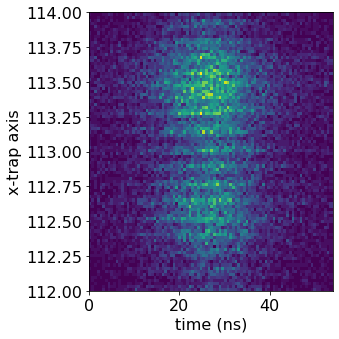

In [38]:
fig = plt.figure(figsize=(5, 5), frameon=True)

font = {'size'   : 16}
plt.rc('font', **font)

plt.hist2d(ion4.tfold1, ion4.xs, bins = 90, range = [(0, 54),(112,114)])
fig.colorbar(h[3], ax = ax0)
plt.ylabel('x-trap axis',fontsize = 16)
plt.xlabel('time (ns)',fontsize = 16)

fig.tight_layout()
plt.show()

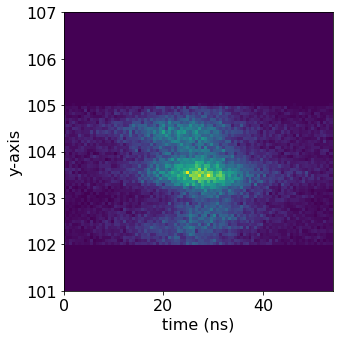

In [39]:
fig = plt.figure(figsize=(5, 5), frameon=True)

font = {'size'   : 16}
plt.rc('font', **font)

plt.hist2d(ion4.tfold1, ion4.ys, bins = 90, range = [(0, 54),(101,107)])
fig.colorbar(h[3], ax = ax0)
plt.ylabel('y-axis',fontsize = 16)
plt.xlabel('time (ns)',fontsize = 16)

fig.tight_layout()
plt.show()

ym = 113.27297549349929
std error = [0.06383868 0.09075899 0.03976841 0.02876444]


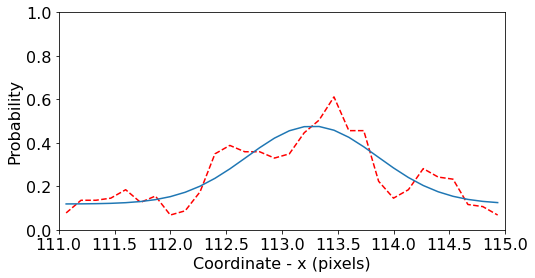

xm = 113.27297549349929 sigma = 0.585790193080601 amplitude =  0.3584114950031894 shift =  0.11864349223368258


In [54]:
#the first argument is interval, the second - chosen time (start)
ion4.timefold(3, 0)
ion4.Gaussian_fit_x(30,0.5,113,0.5)

ym = 113.23978373751754
std error = [0.05962494 0.22794543 0.1693619  0.18099927]


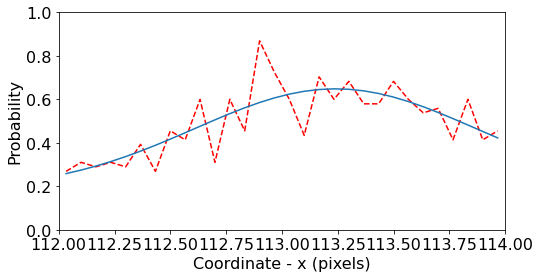

xm = 113.23978373751754 sigma = 0.6295893890150048 amplitude =  0.46376261964540866 shift =  0.18453096706973549


In [146]:
ion4.timefold(3, 3)
ion4.Gaussian_fit_x(30,0.5,113,0.5)

ym = 113.22338788922711
std error = [0.04527328 0.28201945 0.28657657 0.29858852]


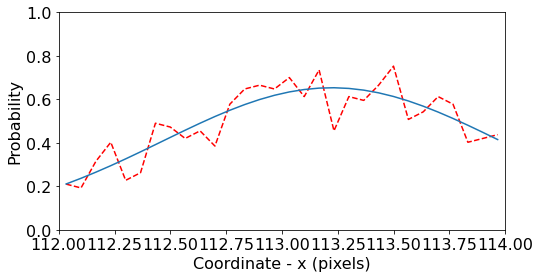

xm = 113.22338788922711 sigma = 0.7590829296384302 amplitude =  0.6257511976971514 shift =  0.027622242385332618


In [147]:
ion4.timefold(3, 6)
ion4.Gaussian_fit_x(30,0.5,113,0.5)

ym = 113.24066613663085
std error = [0.05206725 0.09102719 0.06601646 0.06109449]


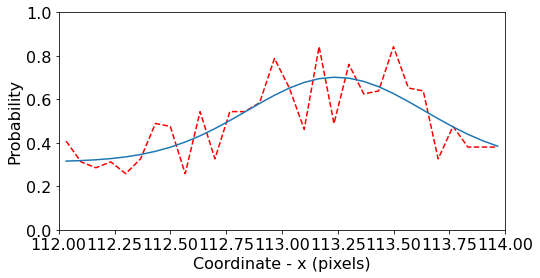

xm = 113.24066613663085 sigma = 0.3959038421394724 amplitude =  0.3895661536548159 shift =  0.31216415761778654


In [102]:
ion4.timefold(3, 9)
ion4.Gaussian_fit_x(30,0.5,113,0.5)

ym = 113.25301789266321
std error = [0.0516788  0.14301749 0.09236954 0.09911304]


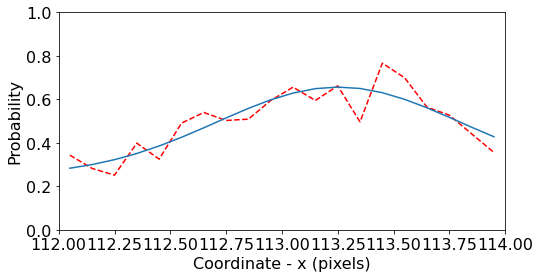

xm = 113.25301789266321 sigma = 0.544729482640179 amplitude =  0.4088549964164971 shift =  0.24751575193627467


In [103]:
ion4.timefold(3, 12)
ion4.Gaussian_fit_x(20,0.5,113,0.5)

ym = 113.26129155624929
std error = [0.0755911  1.99213349 3.42041637 3.44007869]


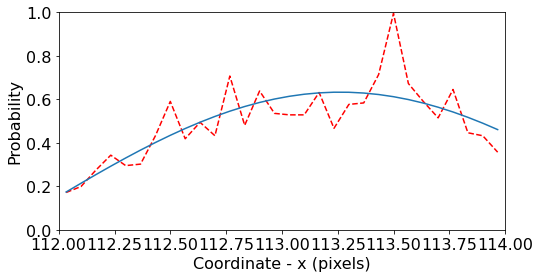

xm = 113.26129155624929 sigma = 1.3731114404863702 amplitude =  1.3934274420874821 shift =  -0.7603560126458528


In [104]:
ion4.timefold(3, 15)
ion4.Gaussian_fit_x(30,0.5,113,0.5)

ym = 113.2118211777975
std error = [0.03603354 0.26549686 0.33793784 0.34963417]


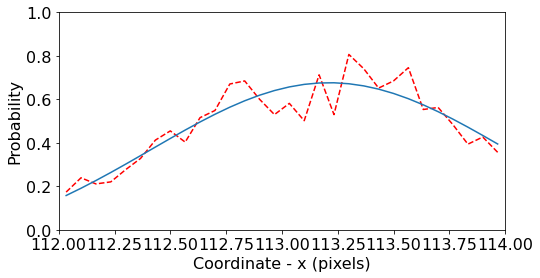

xm = 113.2118211777975 sigma = 0.7984360865134374 amplitude =  0.7818346043652322 shift =  -0.10540385747335955


In [105]:
ion4.timefold(3, 18)
ion4.Gaussian_fit_x(30,0.5,113,0.5)

ym = 113.20317018514571
std error = [0.04011437 0.33797877 0.43018472 0.44292389]


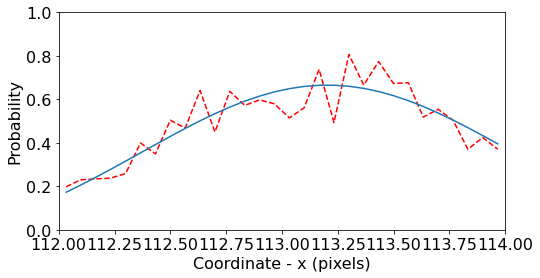

xm = 113.20317018514571 sigma = 0.8305553041246547 amplitude =  0.7831327426913168 shift =  -0.11769218295674155


In [106]:
ion4.timefold(3, 21)
ion4.Gaussian_fit_x(30,0.5,113,0.5)

ym = 113.21613403983235
std error = [0.04463778 0.48807001 0.61060564 0.62322074]


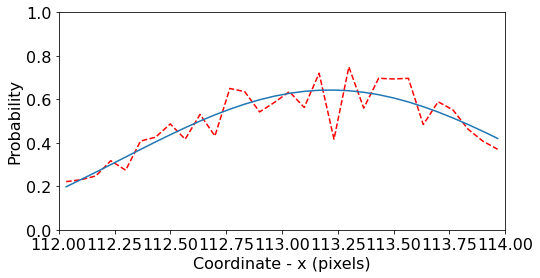

xm = 113.21613403983235 sigma = 0.9332395264875787 amplitude =  0.8059646751485549 shift =  -0.16305230307950133


In [107]:
ion4.timefold(3, 24)
ion4.Gaussian_fit_x(30,0.5,113,0.5)

ym = 113.16459977622281
std error = [0.03358724 0.21184791 0.23028085 0.24063793]


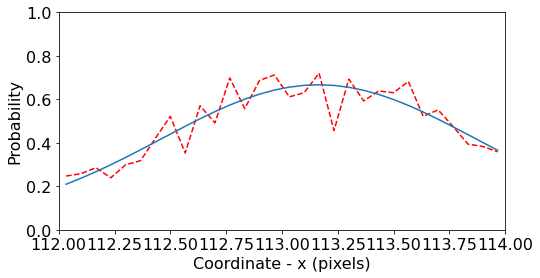

xm = 113.16459977622281 sigma = 0.7036840305532127 amplitude =  0.6306924445660105 shift =  0.03631999899464551


In [108]:
ion4.timefold(3, 27)
ion4.Gaussian_fit_x(30,0.5,113,0.5)

ym = 113.16459977622281
std error = [0.03358724 0.21184791 0.23028085 0.24063793]


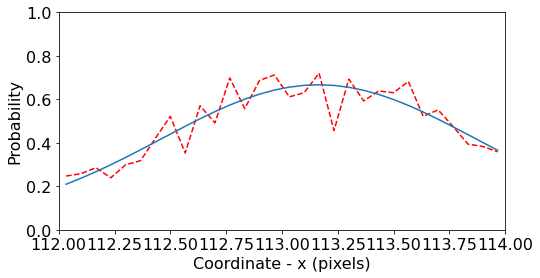

xm = 113.16459977622281 sigma = 0.7036840305532127 amplitude =  0.6306924445660105 shift =  0.03631999899464551


In [109]:
ion4.timefold(3, 27)
ion4.Gaussian_fit_x(30,0.5,113,0.5)

ym = 113.12329114414857
std error = [0.03245429 0.09717775 0.08177295 0.08850771]


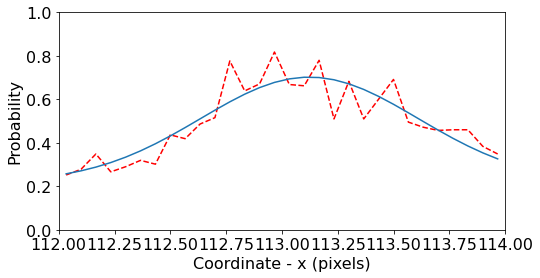

xm = 113.12329114414857 sigma = 0.4877184220727768 amplitude =  0.48469622300360726 shift =  0.21752786324547593


In [110]:
ion4.timefold(3, 30)
ion4.Gaussian_fit_x(30,0.5,113,0.5)

ym = 113.01299891990904
std error = [0.03014001 0.0367933  0.05038828 0.02671273]


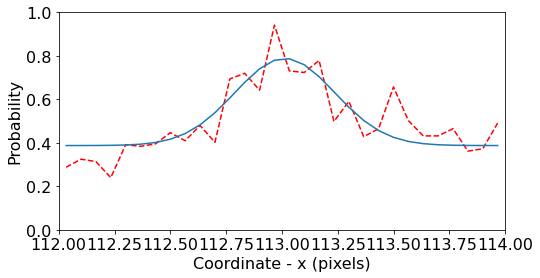

xm = 113.01299891990904 sigma = 0.22396901970381974 amplitude =  0.40083294334675335 shift =  0.3874856390690589


In [111]:
ion4.timefold(3, 33)
ion4.Gaussian_fit_x(30,0.5,113,0.5)

ym = 112.99938014771702
std error = [0.02407727 0.02870989 0.0530006  0.02631879]


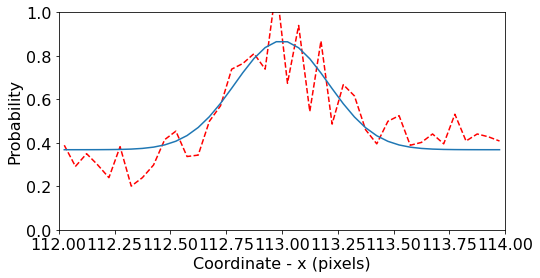

xm = 112.99938014771702 sigma = -0.2101337739352663 amplitude =  0.5000835131359092 shift =  0.3682964334250425


In [112]:
ion4.timefold(3, 36)
ion4.Gaussian_fit_x(40,0.5,113,0.5)

ym = 113.06452650707038
std error = [0.01947811 0.02272978 0.04541631 0.02106984]


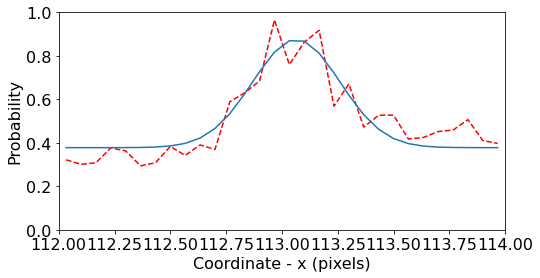

xm = 113.06452650707038 sigma = -0.19575780781791033 amplitude =  0.49789550451213366 shift =  0.3778434145964366


In [113]:
ion4.timefold(3, 39)
ion4.Gaussian_fit_x(30,0.5,113,0.5)

ym = 113.00554460960004
std error = [0.01736237 0.01928244 0.05764626 0.02190347]


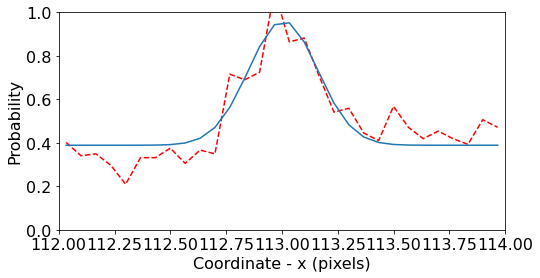

xm = 113.00554460960004 sigma = -0.15490556685185977 amplitude =  -0.5720374453069821 shift =  0.38894159759560426


In [114]:
ion4.timefold(3, 41)
ion4.Gaussian_fit_x(30,0.5,113,0.5)

ym = 113.01273911647803
std error = [0.03468143 0.04294518 0.06147789 0.03379301]


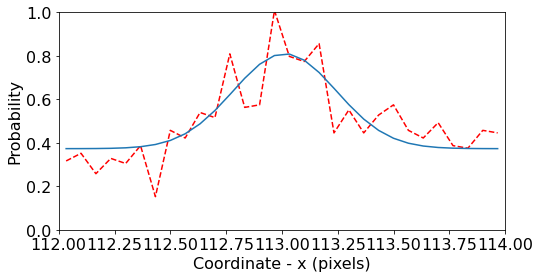

xm = 113.01273911647803 sigma = -0.23161809546093787 amplitude =  0.4368012564417887 shift =  0.3732027888076884


In [115]:
ion4.timefold(3, 44)
ion4.Gaussian_fit_x(30,0.5,113,0.5)

ym = 113.02456939608327
std error = [0.03953118 0.04813946 0.06954415 0.03663096]


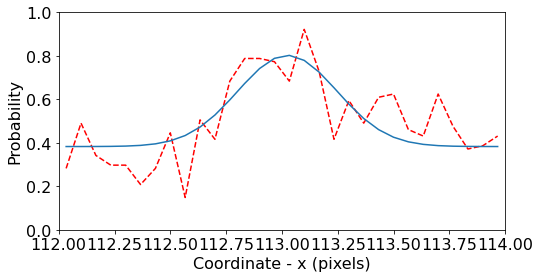

xm = 113.02456939608327 sigma = -0.2226352200555691 amplitude =  0.4196565538735419 shift =  0.3829033141216497


In [116]:
ion4.timefold(3, 47)
ion4.Gaussian_fit_x(30,0.5,113,0.5)

ym = 112.9939837125061
std error = [0.03639555 0.04103224 0.08646972 0.03519989]


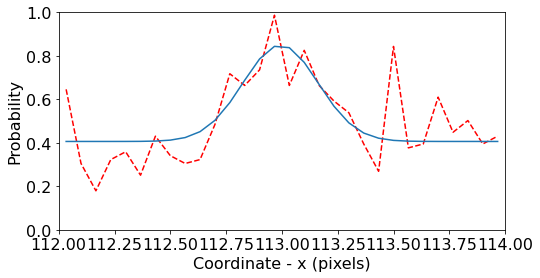

xm = 112.9939837125061 sigma = -0.1686871944830124 amplitude =  -0.4431412979241429 shift =  0.40631193292466816


In [117]:
ion4.timefold(3, 50)
ion4.Gaussian_fit_x(30,0.5,113,0.5)

ym = 113.03352978688915
std error = [0.03108168 0.03413568 0.10812649 0.0387764 ]


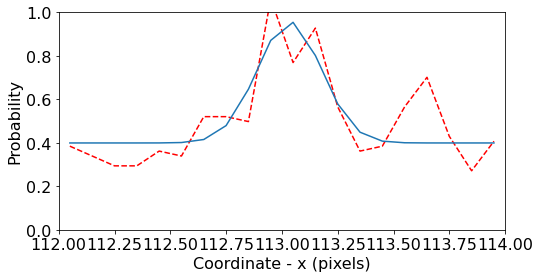

xm = 113.03352978688915 sigma = -0.14374056909559704 amplitude =  0.5585041839336862 shift =  0.39938430547226283


In [118]:
ion4.timefold(3, 53)
ion4.Gaussian_fit_x(20,0.5,113,0.5)

now in y, it is going to change! very pretty sin at the end!

ym = 104.15121000681279
std error = [0.16090002 0.24111636 0.07449538 0.05952532]


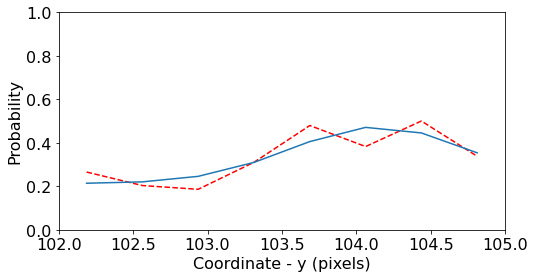

ym = 104.15121000681279 sigma = 0.5962080283108105 amplitude =  -0.2608822146546617 shift =  0.21298509434730495


In [74]:
#the first argument is interval, the second - chosen time (start)
ion4.timefold(3, 0)
ion4.Gaussian_fit_y(8,0.5,103.53295845237241,1)

ym = 104.28900610431594
std error = [0.10573186 0.12860323 0.07999406 0.04265953]


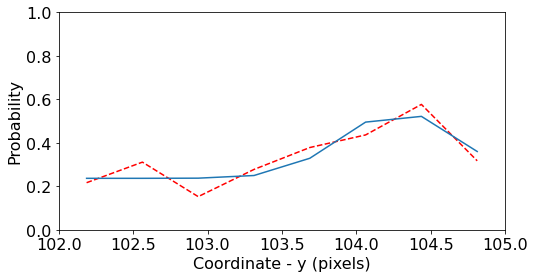

ym = 104.28900610431594 sigma = 0.3880845057419129 amplitude =  0.30653198270660603 shift =  0.23674430919359124


In [75]:
#the first argument is interval, the second - chosen time (start)
ion4.timefold(3, 3)
ion4.Gaussian_fit_y(8,0.5,103.53295845237241,1)

ym = 104.38318982001691
std error = [0.11785693 0.09181282 0.10968072 0.04122178]


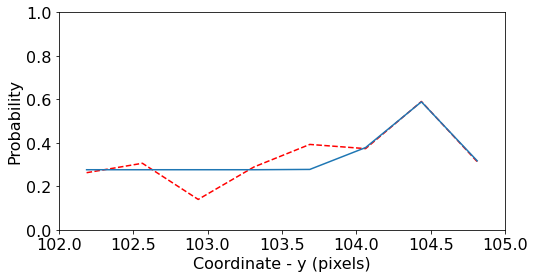

ym = 104.38318982001691 sigma = 0.21119435470597694 amplitude =  -0.3228576515149051 shift =  0.2762563149460769


In [76]:
#the first argument is interval, the second - chosen time (start)
ion4.timefold(3, 6)
ion4.Gaussian_fit_y(8,0.5,103.53295845237241,.5)

ym = 104.46844354092366
std error = [0.11318586 0.07440008 0.09999245 0.03930791]


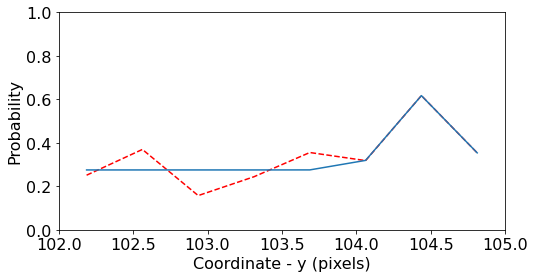

ym = 104.46844354092366 sigma = 0.19982641694815187 amplitude =  -0.345875745627459 shift =  0.27528228407250993


In [77]:
#the first argument is interval, the second - chosen time (start)
ion4.timefold(3, 9)
ion4.Gaussian_fit_y(8,0.5,103.53295845237241,0.5)

ym = 104.30558114063247
std error = [0.12344526 0.15519234 0.07771024 0.04389457]


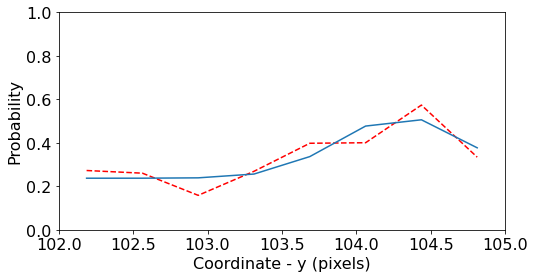

ym = 104.30558114063247 sigma = 0.4282545577913948 amplitude =  -0.28173840988184673 shift =  0.23724552173552266


In [78]:
#the first argument is interval, the second - chosen time (start)
ion4.timefold(3, 12)
ion4.Gaussian_fit_y(8,0.5,103.53295845237241,0.5)

ym = 104.15320264627651
std error = [0.2318115  0.32255694 0.10211769 0.07309101]


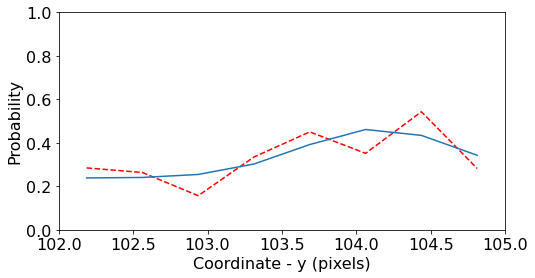

ym = 104.15320264627651 sigma = 0.5302876310807448 amplitude =  0.22633406595734004 shift =  0.23820776339886715


In [79]:
#the first argument is interval, the second - chosen time (start)
ion4.timefold(3, 15)
ion4.Gaussian_fit_y(8,0.5,103.532958452372410,.5)

ym = 104.03553159800343
std error = [0.18352036 0.27408345 0.10699357 0.08557117]


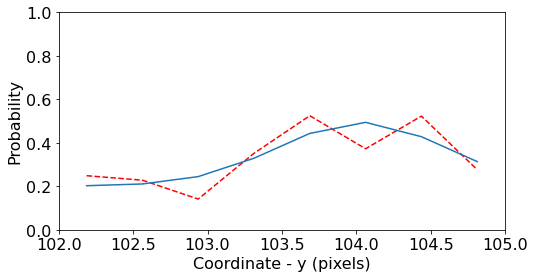

ym = 104.03553159800343 sigma = 0.5608441718968213 amplitude =  0.293135771532822 shift =  0.20145408019558989


In [80]:
#the first argument is interval, the second - chosen time (start)
ion4.timefold(3, 18)
ion4.Gaussian_fit_y(8,0.5,103.53295845237241,0.5)

ym = 103.82827625301398
std error = [0.14369877 0.22691587 0.09464842 0.07981441]


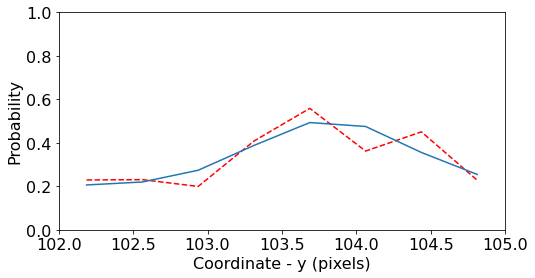

ym = 103.82827625301398 sigma = 0.5215850262130598 amplitude =  0.29983640319336924 shift =  0.20410159738532588


In [81]:
#the first argument is interval, the second - chosen time (start)
ion4.timefold(3, 21)
ion4.Gaussian_fit_y(8,0.5,103.53295845237241,0.5)

ym = 103.58142698149493
std error = [0.07292261 0.08882148 0.09090979 0.03563756]


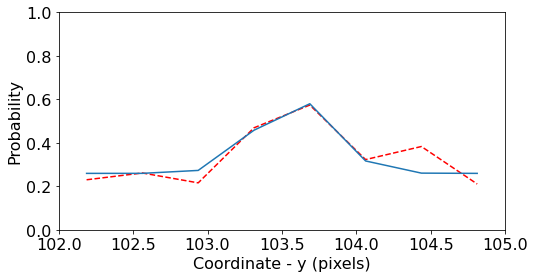

ym = 103.58142698149493 sigma = 0.25266416988397533 amplitude =  0.34974503226709897 shift =  0.25950194381834657


In [82]:
#the first argument is interval, the second - chosen time (start)
ion4.timefold(3, 24)
ion4.Gaussian_fit_y(8,0.5,104,0.5)

ym = 103.55706658041167
std error = [0.05240584 0.06824406 0.06467986 0.02946608]


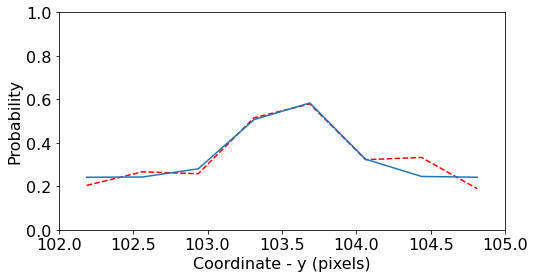

ym = 103.55706658041167 sigma = 0.2903196869148645 amplitude =  0.3779202410027929 shift =  0.24166029193536323


In [83]:
#the first argument is interval, the second - chosen time (start)
ion4.timefold(3, 27)
ion4.Gaussian_fit_y(8,0.5,104,0.5)

ym = 103.4985622660837
std error = [0.0463723  0.06234626 0.05085296 0.02473601]


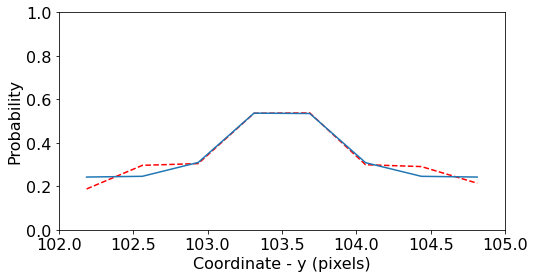

ym = 103.4985622660837 sigma = 0.3081115536651267 amplitude =  0.352682953376129 shift =  0.24253882408083235


In [84]:
#the first argument is interval, the second - chosen time (start)
ion4.timefold(3, 30)
ion4.Gaussian_fit_y(8,0.5,104,0.5)

ym = 103.49324005976989
std error = [0.04249994 0.05611738 0.04929629 0.02460736]


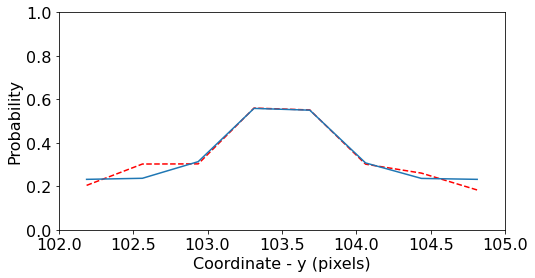

ym = 103.49324005976989 sigma = 0.3154460955477858 amplitude =  0.38463723008655787 shift =  0.23195523052679434


In [85]:
#the first argument is interval, the second - chosen time (start)
ion4.timefold(3, 33)
ion4.Gaussian_fit_y(8,0.5,104,0.5)

ym = 103.4979020106174
std error = [0.07042377 0.09236592 0.06554359 0.03315766]


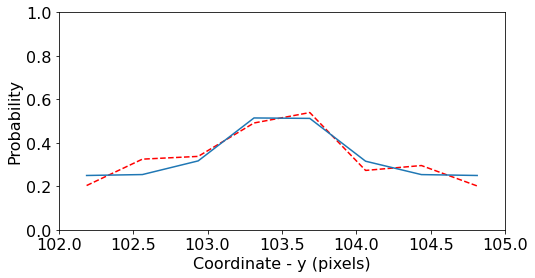

ym = 103.4979020106174 sigma = 0.3193659152052069 amplitude =  0.31322385511365297 shift =  0.2497516343751557


In [86]:
#the first argument is interval, the second - chosen time (start)
ion4.timefold(3, 36)
ion4.Gaussian_fit_y(8,0.5,104,0.5)

ym = 103.48849957957381
std error = [0.05273258 0.0722719  0.05924558 0.0280381 ]


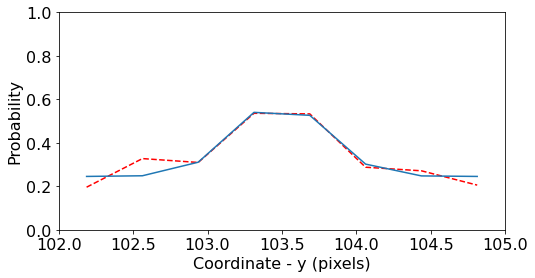

ym = 103.48849957957381 sigma = 0.3008645942123169 amplitude =  0.34971104004502895 shift =  0.24542167864518902


In [87]:
#the first argument is interval, the second - chosen time (start)
ion4.timefold(3, 39)
ion4.Gaussian_fit_y(8,0.5,104,0.5)

ym = 103.50886173737373
std error = [0.09569118 0.13485099 0.09821497 0.04516572]


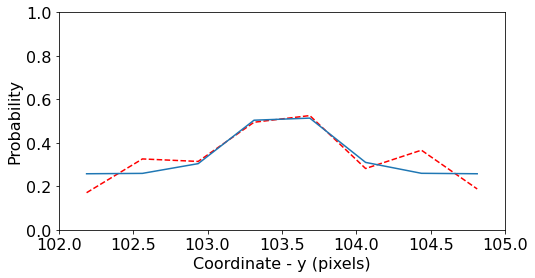

ym = 103.50886173737373 sigma = 0.29394253602984205 amplitude =  0.3078273278215208 shift =  0.25773127593075856


In [88]:
#the first argument is interval, the second - chosen time (start)
ion4.timefold(3, 42)
ion4.Gaussian_fit_y(8,0.5,104,0.5)

ym = 103.57876004163508
std error = [0.05699485 0.07086074 0.05163856 0.02797647]


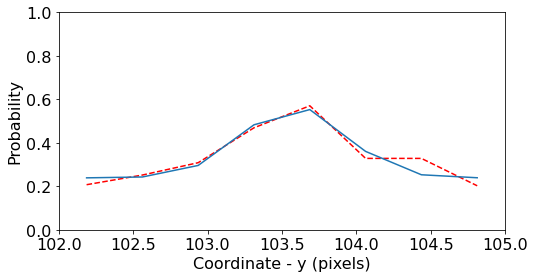

ym = 103.57876004163508 sigma = 0.34233354016430095 amplitude =  0.330318586297857 shift =  0.23885161967668145


In [89]:
#the first argument is interval, the second - chosen time (start)
ion4.timefold(3, 45)
ion4.Gaussian_fit_y(8,0.5,104,0.5)

ym = 103.61426654602225
std error = [0.05499952 0.06830569 0.04277846 0.02413966]


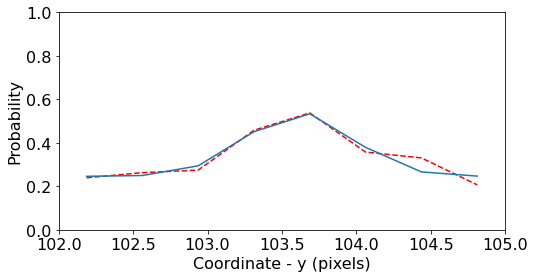

ym = 103.61426654602225 sigma = 0.35626750757823744 amplitude =  0.2937061747179131 shift =  0.24590609173029804


In [90]:
#the first argument is interval, the second - chosen time (start)
ion4.timefold(3, 48)
ion4.Gaussian_fit_y(8,0.5,104,0.5)

ym = 103.98725141004978
std error = [0.17485272 0.28028652 0.07676811 0.06634537]


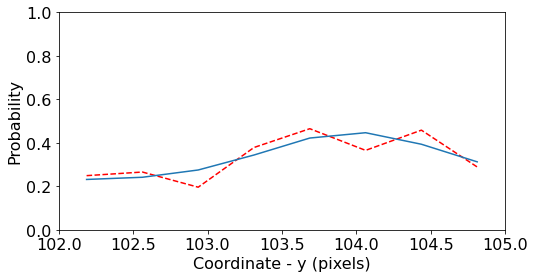

ym = 103.98725141004978 sigma = 0.5932640793237536 amplitude =  0.21886207083846299 shift =  0.22935633759938745


In [91]:
#the first argument is interval, the second - chosen time (start)
ion4.timefold(3, 51)
ion4.Gaussian_fit_y(8,0.5,104,0.5)

In [73]:
ion5 = Ion(117, 102, 122, 105, x, y, fold, T, N2, n)

43914
43914 43914 43914


In [739]:
#the first argument is interval, the second - chosen time (start)
ion5.timefold(5, 20)

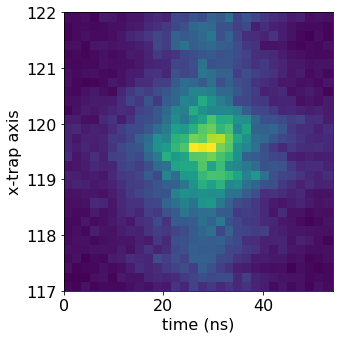

In [740]:
fig = plt.figure(figsize=(5, 5), frameon=True)

font = {'size'   : 16}
plt.rc('font', **font)

plt.hist2d(ion5.tfold1, ion5.xs, bins = 30, range = [(0, 54),(117,122)])
fig.colorbar(h[3], ax = ax0)
plt.ylabel('x-trap axis',fontsize = 16)
plt.xlabel('time (ns)',fontsize = 16)

fig.tight_layout()
plt.show()

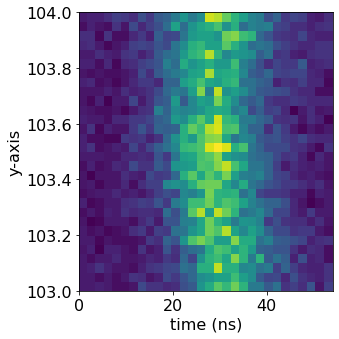

In [741]:
fig = plt.figure(figsize=(5, 5), frameon=True)

font = {'size'   : 16}
plt.rc('font', **font)

plt.hist2d(ion5.tfold1, ion5.ys, bins = 30, range = [(0, 54),(103,104)])
fig.colorbar(h[3], ax = ax0)
plt.ylabel('y-axis',fontsize = 16)
plt.xlabel('time (ns)',fontsize = 16)

fig.tight_layout()
plt.show()

ym = 104.06377847205574
std error = [0.0569164  0.06240602 0.04748862 0.01699868]


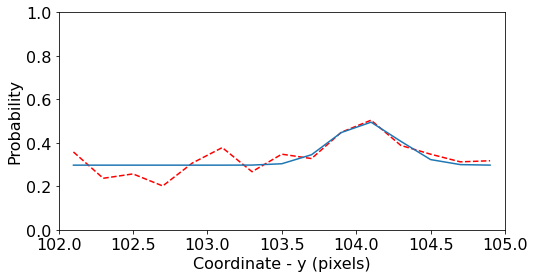

ym = 104.06377847205574 sigma = 0.21504098994993373 amplitude =  0.20052376456304424 shift =  0.29730415919829134


In [749]:
#the first argument is interval, the second - chosen time (start)
ion5.timefold(6, 0)
ion5.Gaussian_fit_y(15,0.5,104,0.5)

ym = 104.30849897691444
std error = [0.05142443 0.06041784 0.03130188 0.01543037]


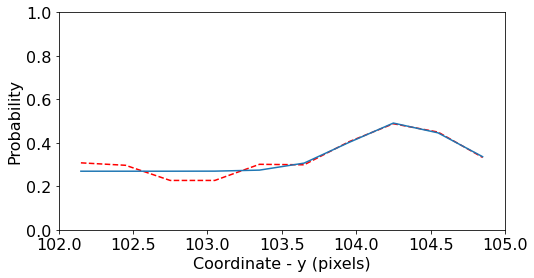

ym = 104.30849897691444 sigma = 0.3473404503068196 amplitude =  0.22459026454823097 shift =  0.26945240502866447


In [750]:
#the first argument is interval, the second - chosen time (start)
ion5.timefold(6, 6)
ion5.Gaussian_fit_y(10,0.5,104,0.5)

ym = 104.3493874524497
std error = [0.04989141 0.05723897 0.03831476 0.01719235]


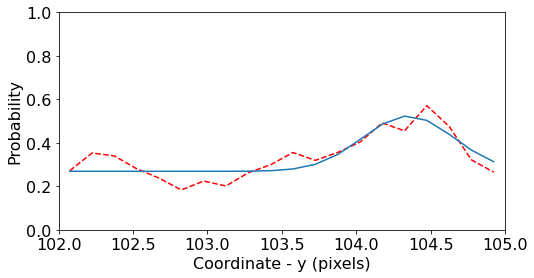

ym = 104.3493874524497 sigma = 0.3067093040661005 amplitude =  0.25463014411675483 shift =  0.26912823604759406


In [751]:
#the first argument is interval, the second - chosen time (start)
ion5.timefold(6, 12)
ion5.Gaussian_fit_y(20,0.5,104,0.5)

ym = 104.04369566964255
std error = [0.06788422 0.09728099 0.03169655 0.02398312]


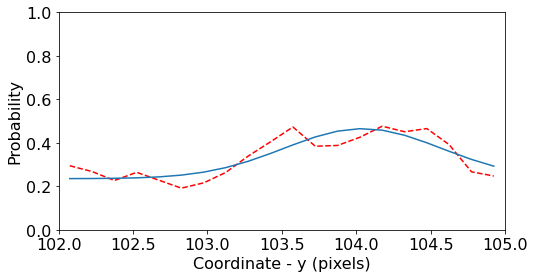

ym = 104.04369566964255 sigma = 0.5290079110976563 amplitude =  0.2299151071869479 shift =  0.23525615503666347


In [752]:
#the first argument is interval, the second - chosen time (start)
ion5.timefold(6, 18)
ion5.Gaussian_fit_y(20,0.5,104,0.5)

ym = 103.76426354002744
std error = [0.05214644 0.10635464 0.02883607 0.02903839]


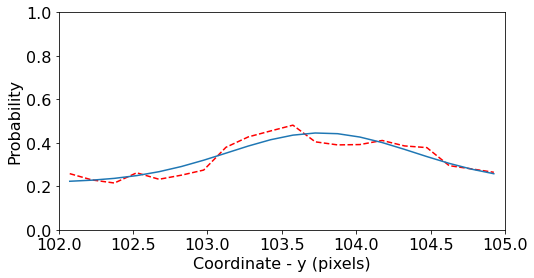

ym = 103.76426354002744 sigma = 0.6243927671904456 amplitude =  0.22824587066433208 shift =  0.21734537313830837


In [753]:
#the first argument is interval, the second - chosen time (start)
ion5.timefold(6, 24)
ion5.Gaussian_fit_y(20,0.5,104,0.5)

ym = 103.57676966039803
std error = [0.0519799  0.11834012 0.0387635  0.04078011]


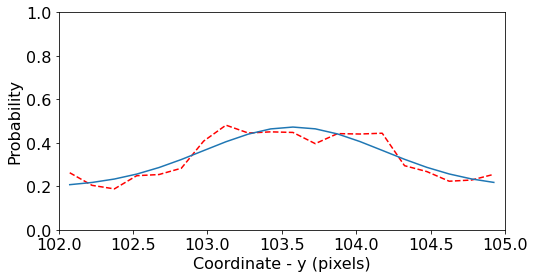

ym = 103.57676966039803 sigma = 0.6056533604864734 amplitude =  0.2778618379517727 shift =  0.19465695592787718


In [754]:
#the first argument is interval, the second - chosen time (start)
ion5.timefold(6, 30)
ion5.Gaussian_fit_y(20,0.5,104,0.5)

ym = 103.47925338334397
std error = [0.0581811  0.11732612 0.03995852 0.04010995]


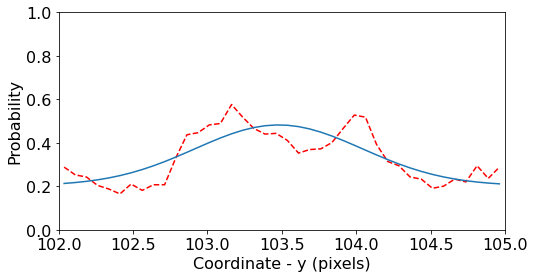

ym = 103.47925338334397 sigma = 0.5638701533784318 amplitude =  0.27972576104019486 shift =  0.2025727502787284


In [757]:
#the first argument is interval, the second - chosen time (start)
ion5.timefold(6, 36)
ion5.Gaussian_fit_y(40,0.5,104,0.5)

ym = 103.52797965728814
std error = [0.07180413 0.16219191 0.0442376  0.04645897]


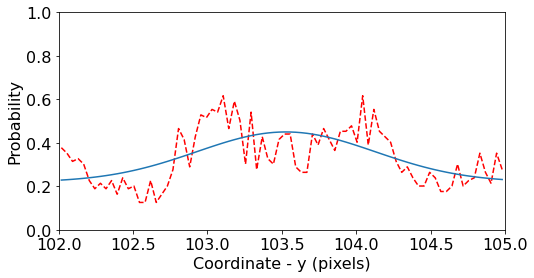

ym = 103.52797965728814 sigma = 0.5998117433551305 amplitude =  0.2310613749495721 shift =  0.2189766548838074


In [765]:
#the first argument is interval, the second - chosen time (start)
ion5.timefold(6, 42)
ion5.Gaussian_fit_y(80,0.5,104,0.5)

ym = 103.78828049725178
std error = [0.06782706 0.13950323 0.04605949 0.04654106]


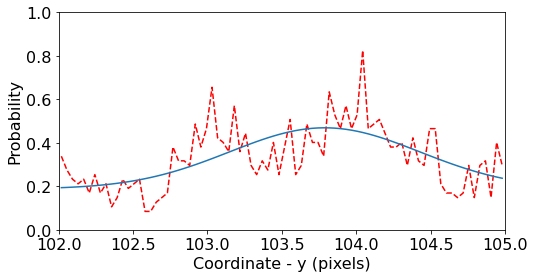

ym = 103.78828049725178 sigma = 0.6396555819564025 amplitude =  0.2814274397631634 shift =  0.18768358484099373


In [766]:
#the first argument is interval, the second - chosen time (start)
ion5.timefold(6, 48)
ion5.Gaussian_fit_y(80,0.5,104,0.5)

In [767]:
ion6 = Ion(124, 102, 130, 105, x, y, fold, T, N2, n)

19790
18131 18131 18131


In [769]:
#the first argument is interval, the second - chosen time (start)
ion6.timefold(5, 20)

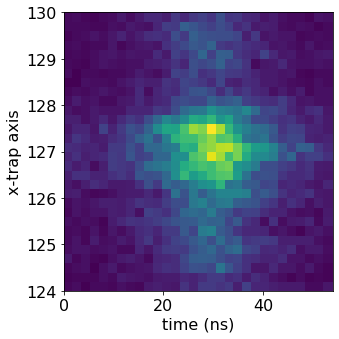

In [770]:
fig = plt.figure(figsize=(5, 5), frameon=True)

font = {'size'   : 16}
plt.rc('font', **font)

plt.hist2d(ion6.tfold1, ion6.xs, bins = 30, range = [(0, 54),(124,130)])
fig.colorbar(h[3], ax = ax0)
plt.ylabel('x-trap axis',fontsize = 16)
plt.xlabel('time (ns)',fontsize = 16)

fig.tight_layout()
plt.show()

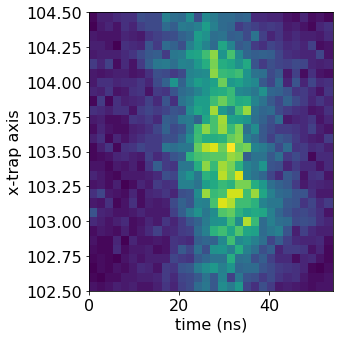

In [771]:
fig = plt.figure(figsize=(5, 5), frameon=True)

font = {'size'   : 16}
plt.rc('font', **font)

plt.hist2d(ion6.tfold1, ion6.ys, bins = 30, range = [(0, 54),(102.5,104.5)])
fig.colorbar(h[3], ax = ax0)
plt.ylabel('x-trap axis',fontsize = 16)
plt.xlabel('time (ns)',fontsize = 16)

fig.tight_layout()
plt.show()

ym = 103.8874895317131
std error = [0.15105166 0.23106639 0.06701782 0.05483055]


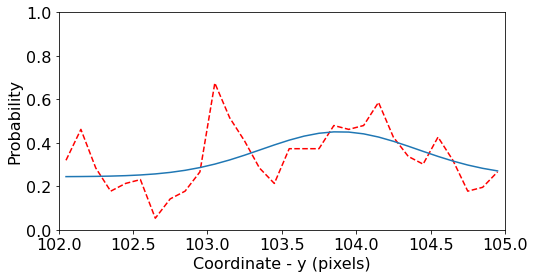

ym = 103.8874895317131 sigma = 0.5253819257709311 amplitude =  -0.20681781093032217 shift =  0.24409994810399


In [776]:
#the first argument is interval, the second - chosen time (start)
ion6.timefold(6, 0)
ion6.Gaussian_fit_y(30,0.5,103.5,0.2)

ym = 104.20120054499284
std error = [0.09512791 0.12433377 0.03479163 0.02214298]


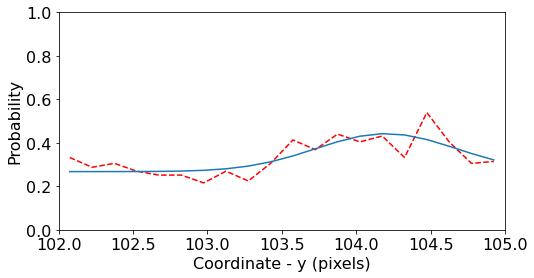

ym = 104.20120054499284 sigma = 0.4711358896566487 amplitude =  0.1745588155094417 shift =  0.2676627125834294


In [801]:
#the first argument is interval, the second - chosen time (start)
ion6.timefold(6, 6)
ion6.Gaussian_fit_y(20,0.5,103.5,0.2)

ym = 104.14547528078059
std error = [0.13575457 0.18611558 0.07102964 0.0524262 ]


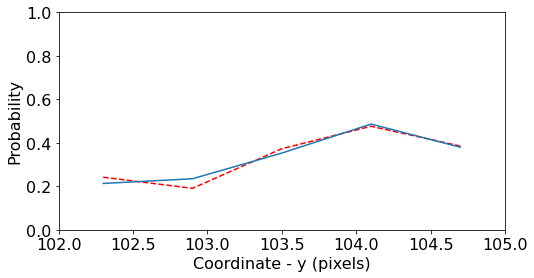

ym = 104.14547528078059 sigma = 0.5578122501820213 amplitude =  -0.2751108274497709 shift =  0.21197431159277658


In [804]:
#the first argument is interval, the second - chosen time (start)
ion6.timefold(6, 12)
ion6.Gaussian_fit_y(5,0.5,103.5,0.2)

ym = 103.91878056362147
std error = [0.07048699 0.10645705 0.03408756 0.02754204]


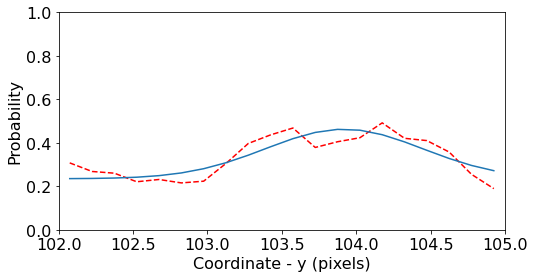

ym = 103.91878056362147 sigma = 0.5277877900895862 amplitude =  0.22780131511428317 shift =  0.2348893850730877


In [785]:
#the first argument is interval, the second - chosen time (start)
ion6.timefold(6, 18)
ion6.Gaussian_fit_y(20,0.5,103.5,0.2)

ym = 103.61682640709718
std error = [0.03879543 0.05864958 0.02261443 0.01774161]


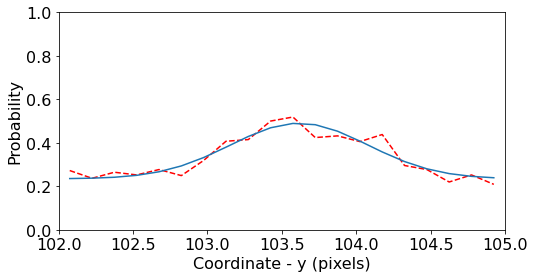

ym = 103.61682640709718 sigma = 0.4626211448361937 amplitude =  0.25561702308391626 shift =  0.2346813951207915


In [786]:
#the first argument is interval, the second - chosen time (start)
ion6.timefold(6, 24)
ion6.Gaussian_fit_y(20,0.5,103.5,0.2)

ym = 103.41722518982915
std error = [0.03868976 0.0635913  0.0275186  0.02374069]


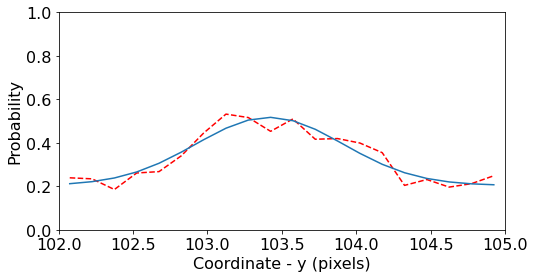

ym = 103.41722518982915 sigma = 0.49525523126265597 amplitude =  0.3131688589953753 shift =  0.20409229184119418


In [787]:
#the first argument is interval, the second - chosen time (start)
ion6.timefold(6, 30)
ion6.Gaussian_fit_y(20,0.5,103.5,0.2)

ym = 103.30935316507907
std error = [0.05876697 0.09012266 0.04649665 0.03734816]


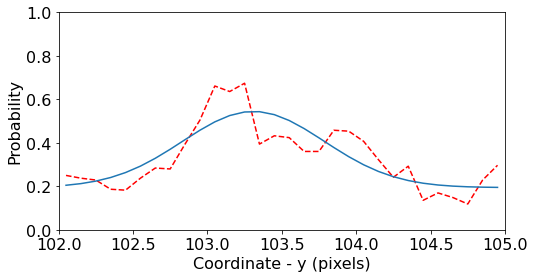

ym = 103.30935316507907 sigma = 0.4769781371128475 amplitude =  0.3503982539391494 shift =  0.19412988546685422


In [794]:
#the first argument is interval, the second - chosen time (start)
ion6.timefold(6, 36)
ion6.Gaussian_fit_y(30,0.5,103.5,0.2)

ym = 103.39763542182418
std error = [0.05783727 0.11770336 0.05662825 0.0570749 ]


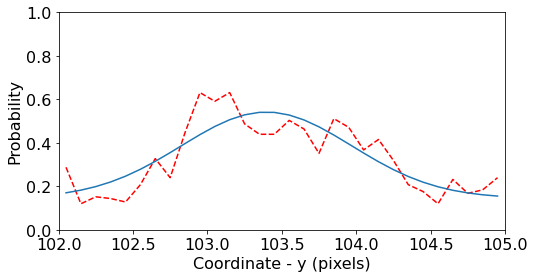

ym = 103.39763542182418 sigma = 0.5744626315540281 amplitude =  0.39679126796025804 shift =  0.14478989004548823


In [797]:
#the first argument is interval, the second - chosen time (start)
ion6.timefold(6, 42)
ion6.Gaussian_fit_y(30,0.5,103.5,0.2)

ym = 103.57018684284353
std error = [0.08210182 0.16878059 0.05055842 0.05121117]


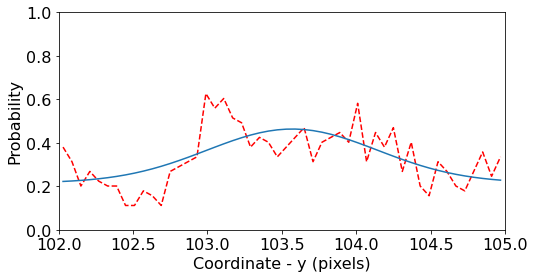

ym = 103.57018684284353 sigma = 0.5737553367853061 amplitude =  0.24779757202771874 shift =  0.2156593769849671


In [800]:
#the first argument is interval, the second - chosen time (start)
ion6.timefold(6, 48)
ion6.Gaussian_fit_y(50,0.5,103.5,0.2)

the 1st ion

In [824]:
ion1 = Ion(88, 102, 92, 105, x, y, fold, T, N2, n)

8669
7867 7867 7867


In [825]:
#the first argument is interval, the second - chosen time (start)
ion1.timefold(5, 20)

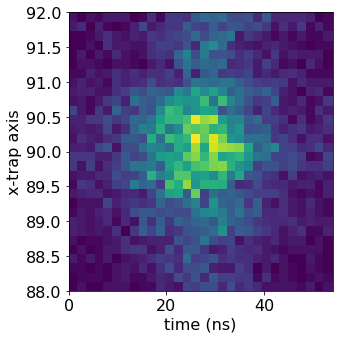

In [827]:
fig = plt.figure(figsize=(5, 5), frameon=True)

font = {'size'   : 16}
plt.rc('font', **font)

plt.hist2d(ion1.tfold1, ion1.xs, bins = 30, range = [(0, 54),(88,92)])
fig.colorbar(h[3], ax = ax0)
plt.ylabel('x-trap axis',fontsize = 16)
plt.xlabel('time (ns)',fontsize = 16)

fig.tight_layout()
plt.show()

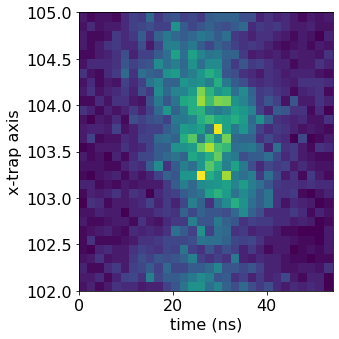

In [829]:
fig = plt.figure(figsize=(5, 5), frameon=True)

font = {'size'   : 16}
plt.rc('font', **font)

plt.hist2d(ion1.tfold1, ion1.ys, bins = 30, range = [(0, 54),(102,105)])
fig.colorbar(h[3], ax = ax0)
plt.ylabel('x-trap axis',fontsize = 16)
plt.xlabel('time (ns)',fontsize = 16)

fig.tight_layout()
plt.show()

ym = 104.32355019843169
std error = [0.10260559 0.1091179  0.08163177 0.02405606]


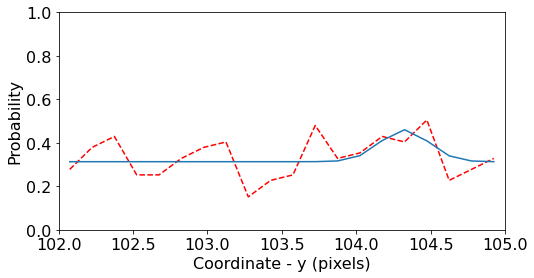

ym = 104.32355019843169 sigma = 0.16354729875669816 amplitude =  0.14707884829228124 shift =  0.31323509001178845


In [850]:
#the first argument is interval, the second - chosen time (start)
ion1.timefold(6, 0)
ion1.Gaussian_fit_y(20,0.5,103.5,0.2)

ym = 104.43728809430189
std error = [0.04500918 0.04857309 0.07164191 0.02361952]


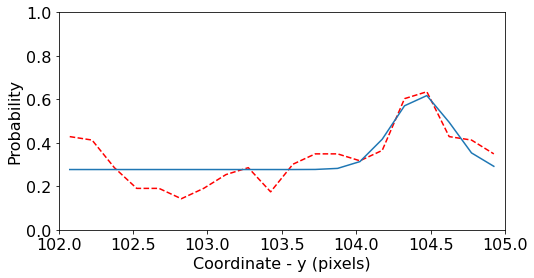

ym = 104.43728809430189 sigma = 0.19424935400533477 amplitude =  0.3466189516334847 shift =  0.27715977516980395


In [851]:
#the first argument is interval, the second - chosen time (start)
ion1.timefold(6, 6)
ion1.Gaussian_fit_y(20,0.5,104.5,0.2)

ym = 104.28346780793117
std error = [0.08906916 0.10866432 0.04546384 0.02440343]


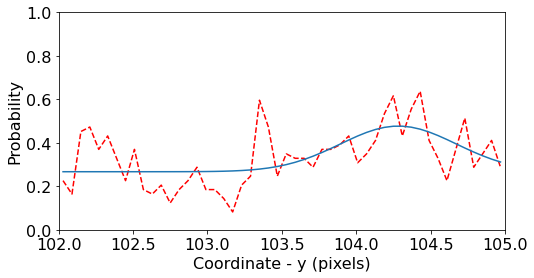

ym = 104.28346780793117 sigma = 0.39042776756070313 amplitude =  0.2099429510525518 shift =  0.2671129145929197


In [855]:
#the first argument is interval, the second - chosen time (start)
ion1.timefold(6, 12)
ion1.Gaussian_fit_y(50,0.5,104.5,0.2)

ym = 104.0814888501094
std error = [0.09470184 0.13482573 0.03875525 0.0290027 ]


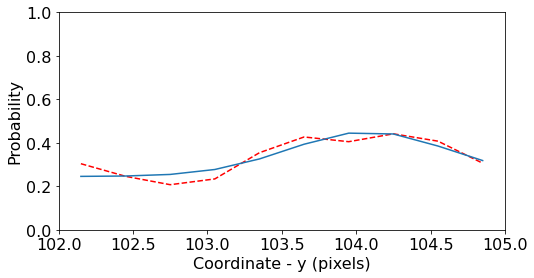

ym = 104.0814888501094 sigma = 0.5346646896055669 amplitude =  0.20523533009533088 shift =  0.24539654495547683


In [875]:
#the first argument is interval, the second - chosen time (start)
ion1.timefold(6, 18)
ion1.Gaussian_fit_y(10,0.5,104.5,0.2)

ym = 103.74068995460726
std error = [0.04251961 0.06499663 0.02851054 0.02291891]


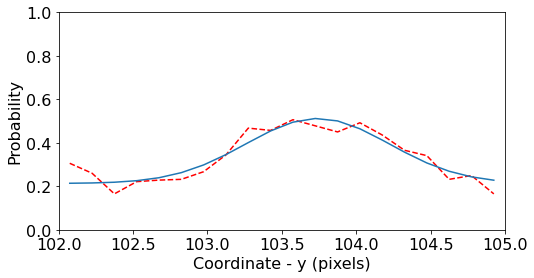

ym = 103.74068995460726 sigma = 0.48311802668600706 amplitude =  -0.29883478745790965 shift =  0.2132567272988573


In [859]:
#the first argument is interval, the second - chosen time (start)
ion1.timefold(6, 24)
ion1.Gaussian_fit_y(20,0.5,104.5,0.2)

ym = 103.59213293945496
std error = [0.05594718 0.11343741 0.04154252 0.04180017]


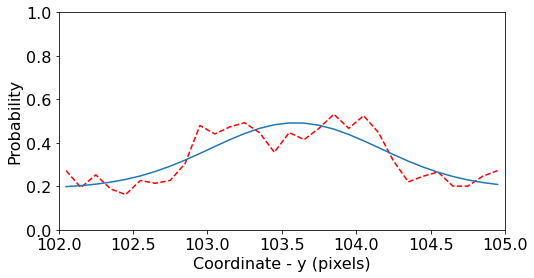

ym = 103.59213293945496 sigma = 0.5717188798106801 amplitude =  0.3015878278212573 shift =  0.1906328966220444


In [861]:
#the first argument is interval, the second - chosen time (start)
ion1.timefold(6, 30)
ion1.Gaussian_fit_y(30,0.5,104.5,0.2)

ym = 103.42966796019861
std error = [0.09192527 0.15936262 0.06541642 0.05931307]


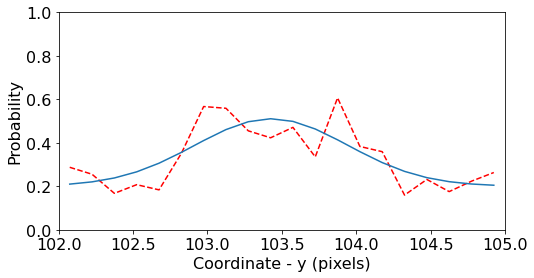

ym = 103.42966796019861 sigma = -0.5144328045777345 amplitude =  -0.3103729817541123 shift =  0.20042420711190073


In [865]:
#the first argument is interval, the second - chosen time (start)
ion1.timefold(6, 36)
ion1.Gaussian_fit_y(20,0.5,104.5,0.2)

ym = 103.59852566573899
std error = [0.11785232 0.18209448 0.064191   0.05165454]


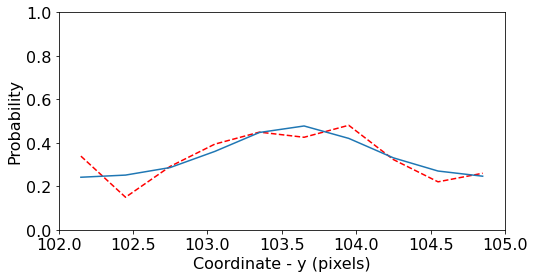

ym = 103.59852566573899 sigma = 0.4692557706686197 amplitude =  -0.2392505032715987 shift =  0.2396640025130223


In [871]:
#the first argument is interval, the second - chosen time (start)
ion1.timefold(6, 42)
ion1.Gaussian_fit_y(10,0.5,104.5,0.2)

ym = 104.19491153023245
std error = [0.11771287 0.14095515 0.0649173  0.03449961]


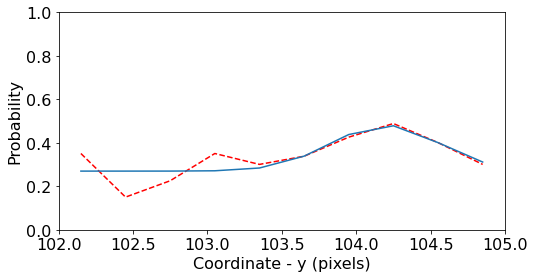

ym = 104.19491153023245 sigma = 0.3639039412415808 amplitude =  0.2109027231601897 shift =  0.2699376833019074


In [873]:
#the first argument is interval, the second - chosen time (start)
ion1.timefold(6, 48)
ion1.Gaussian_fit_y(10,0.5,104.5,0.2)

the 2nd ion

In [880]:
ion2 = Ion(94, 102, 97, 105, x, y, fold, T, N2, n)

27869
25314 25314 25314


In [881]:
#the first argument is interval, the second - chosen time (start)
ion2.timefold(5, 20)

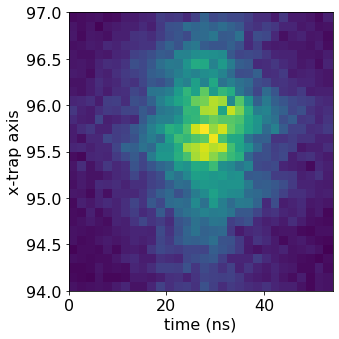

In [883]:
fig = plt.figure(figsize=(5, 5), frameon=True)

font = {'size'   : 16}
plt.rc('font', **font)

plt.hist2d(ion2.tfold1, ion2.xs, bins = 30, range = [(0, 54),(94,97)])
fig.colorbar(h[3], ax = ax0)
plt.ylabel('x-trap axis',fontsize = 16)
plt.xlabel('time (ns)',fontsize = 16)

fig.tight_layout()
plt.show()

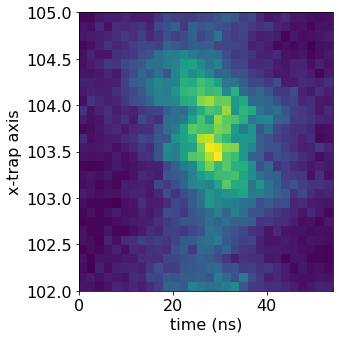

In [884]:
fig = plt.figure(figsize=(5, 5), frameon=True)

font = {'size'   : 16}
plt.rc('font', **font)

plt.hist2d(ion2.tfold1, ion2.ys, bins = 30, range = [(0, 54),(102,105)])
fig.colorbar(h[3], ax = ax0)
plt.ylabel('x-trap axis',fontsize = 16)
plt.xlabel('time (ns)',fontsize = 16)

fig.tight_layout()
plt.show()

ym = 104.32352375364471
std error = [0.10262176 0.10913744 0.08162546 0.0240569 ]


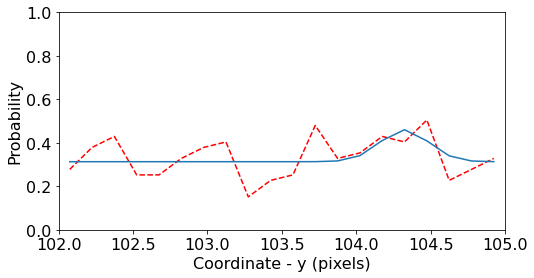

ym = 104.32352375364471 sigma = 0.16357474757035761 amplitude =  0.14706946360109466 shift =  0.31323300003982874


In [897]:
#the first argument is interval, the second - chosen time (start)
ion1.timefold(6, 0)
ion1.Gaussian_fit_y(20,0.5,104.5,0.2)

ym = 104.43728809430189
std error = [0.04500918 0.04857309 0.07164191 0.02361952]


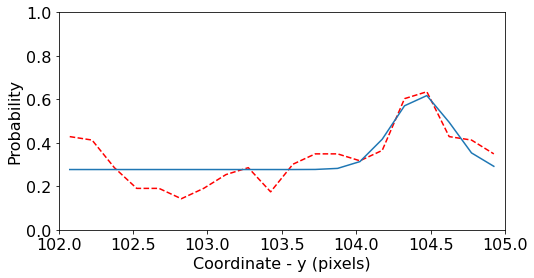

ym = 104.43728809430189 sigma = 0.19424935400533477 amplitude =  0.3466189516334847 shift =  0.27715977516980395


In [899]:
#the first argument is interval, the second - chosen time (start)
ion1.timefold(6, 6)
ion1.Gaussian_fit_y(20,0.5,104.5,0.2)

ym = 104.28842983150165
std error = [0.08780049 0.10699782 0.04506039 0.02407483]


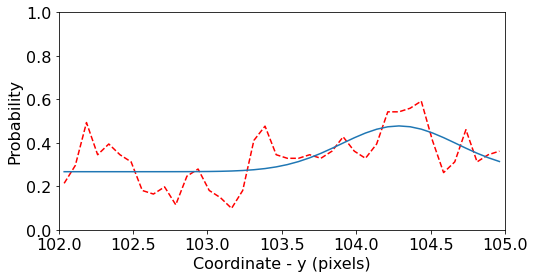

ym = 104.28842983150165 sigma = 0.38904162602671144 amplitude =  0.21050444667343343 shift =  0.2671978520321063


In [902]:
#the first argument is interval, the second - chosen time (start)
ion1.timefold(6, 12)
ion1.Gaussian_fit_y(40,0.5,104.5,0.2)

ym = 104.09619986779258
std error = [0.06968569 0.09843896 0.0285913  0.02111473]


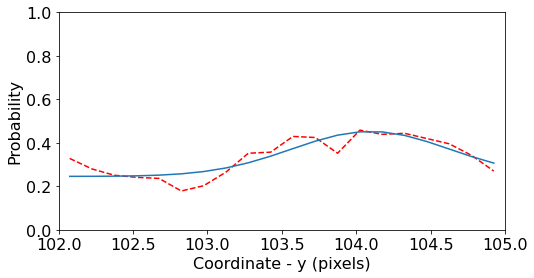

ym = 104.09619986779258 sigma = 0.5307410980333653 amplitude =  0.20683862757448515 shift =  0.24562680874189968


In [906]:
#the first argument is interval, the second - chosen time (start)
ion1.timefold(6, 18)
ion1.Gaussian_fit_y(20,0.5,104.5,0.2)

ym = 103.74068995460726
std error = [0.04251961 0.06499663 0.02851054 0.02291891]


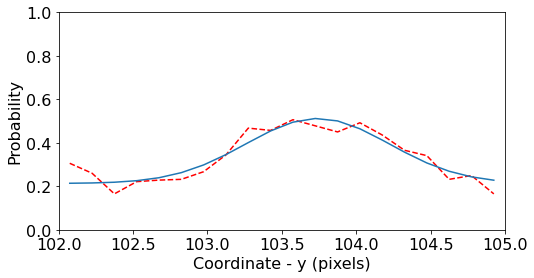

ym = 103.74068995460726 sigma = 0.48311802668600706 amplitude =  -0.29883478745790965 shift =  0.2132567272988573


In [907]:
#the first argument is interval, the second - chosen time (start)
ion1.timefold(6, 24)
ion1.Gaussian_fit_y(20,0.5,104.5,0.2)

ym = 103.59213293945496
std error = [0.05594718 0.11343741 0.04154252 0.04180017]


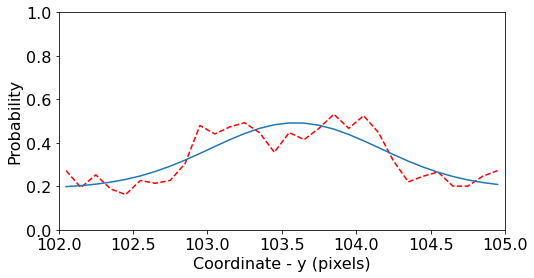

ym = 103.59213293945496 sigma = 0.5717188798106801 amplitude =  0.3015878278212573 shift =  0.1906328966220444


In [909]:
#the first argument is interval, the second - chosen time (start)
ion1.timefold(6, 30)
ion1.Gaussian_fit_y(30,0.5,104.5,0.2)

ym = 103.42966796019861
std error = [0.09192527 0.15936262 0.06541642 0.05931307]


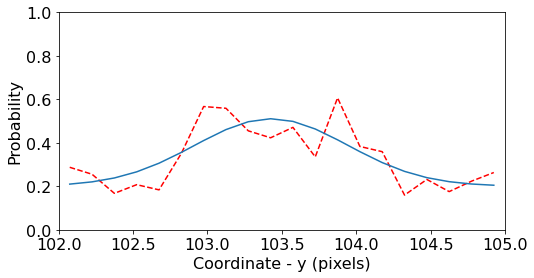

ym = 103.42966796019861 sigma = -0.5144328045777345 amplitude =  -0.3103729817541123 shift =  0.20042420711190073


In [913]:
#the first argument is interval, the second - chosen time (start)
ion1.timefold(6, 36)
ion1.Gaussian_fit_y(20,0.5,104.5,0.2)

ym = 103.59852566573899
std error = [0.11785232 0.18209448 0.064191   0.05165454]


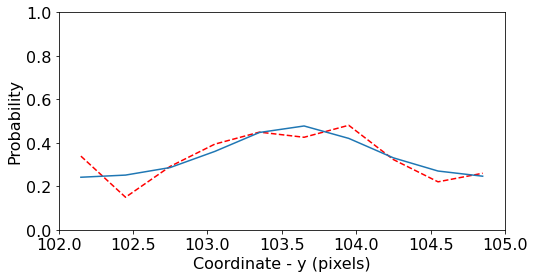

ym = 103.59852566573899 sigma = 0.4692557706686197 amplitude =  -0.2392505032715987 shift =  0.2396640025130223


In [915]:
#the first argument is interval, the second - chosen time (start)
ion1.timefold(6, 42)
ion1.Gaussian_fit_y(10,0.5,104.5,0.2)

ym = 104.19491153023245
std error = [0.11771287 0.14095515 0.0649173  0.03449961]


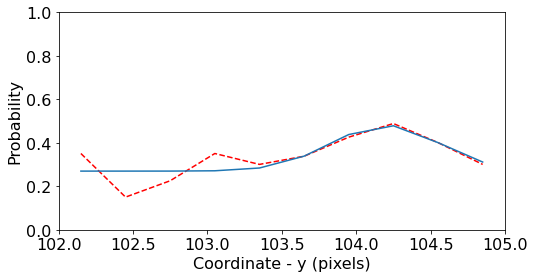

ym = 104.19491153023245 sigma = 0.3639039412415808 amplitude =  0.2109027231601897 shift =  0.2699376833019074


In [916]:
#the first argument is interval, the second - chosen time (start)
ion1.timefold(6, 48)
ion1.Gaussian_fit_y(10,0.5,104.5,0.2)

In [935]:
ion4 = Ion(112, 102, 114, 105, x, y, fold, T, N2, n)

30369
27615 27615 27615


In [937]:
#the first argument is interval, the second - chosen time (start)
ion4.timefold(5, 20)

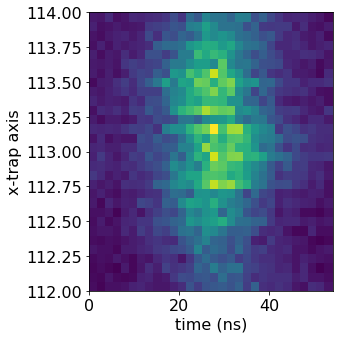

In [939]:
fig = plt.figure(figsize=(5, 5), frameon=True)

font = {'size'   : 16}
plt.rc('font', **font)

plt.hist2d(ion4.tfold1, ion4.xs, bins = 30, range = [(0, 54),(112,114)])
fig.colorbar(h[3], ax = ax0)
plt.ylabel('x-trap axis',fontsize = 16)
plt.xlabel('time (ns)',fontsize = 16)

fig.tight_layout()
plt.show()

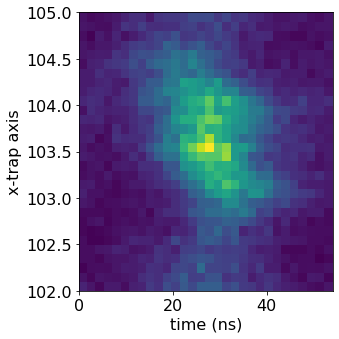

In [940]:
fig = plt.figure(figsize=(5, 5), frameon=True)

font = {'size'   : 16}
plt.rc('font', **font)

plt.hist2d(ion4.tfold1, ion4.ys, bins = 30, range = [(0, 54),(102,105)])
fig.colorbar(h[3], ax = ax0)
plt.ylabel('x-trap axis',fontsize = 16)
plt.xlabel('time (ns)',fontsize = 16)

fig.tight_layout()
plt.show()

ym = 104.09723225594009
std error = [0.03823401 0.04581888 0.04109634 0.02145108]


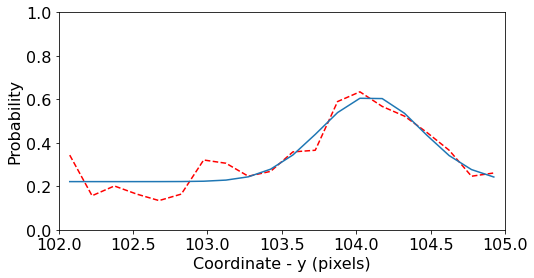

ym = 104.09723225594009 sigma = 0.34266710434989134 amplitude =  0.39184860325179227 shift =  0.2215859668983741


In [941]:
#the first argument is interval, the second - chosen time (start)
ion4.timefold(6, 0)
ion4.Gaussian_fit_y(20,0.5,104.5,0.2)

ym = 104.34022952230569
std error = [0.05261785 0.06707341 0.03818004 0.0220605 ]


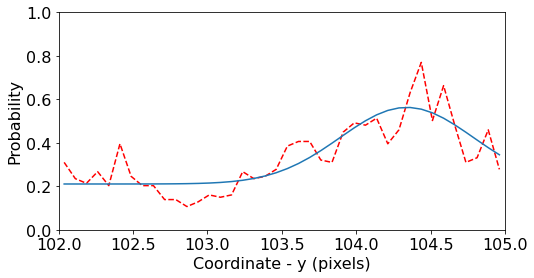

ym = 104.34022952230569 sigma = 0.44814013704626504 amplitude =  0.35231482671277137 shift =  0.21067937774670445


In [970]:
#the first argument is interval, the second - chosen time (start)
ion4.timefold(6, 6)
ion4.Gaussian_fit_y(40,0.5,104,0.2)

ym = 104.15531309150522
std error = [0.04384939 0.05833594 0.03463982 0.02301652]


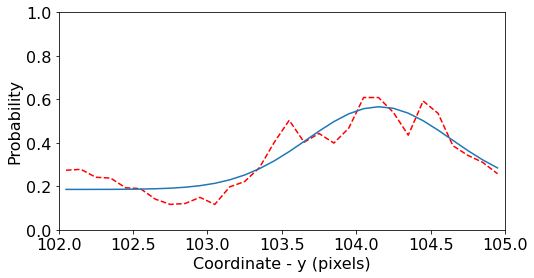

ym = 104.15531309150522 sigma = 0.4841771095283454 amplitude =  0.38027667525198755 shift =  0.18568622956893946


In [950]:
#the first argument is interval, the second - chosen time (start)
ion4.timefold(6, 12)
ion4.Gaussian_fit_y(30,0.5,104.5,0.2)

ym = 103.89552981356857
std error = [0.03202714 0.04563543 0.03032626 0.02258727]


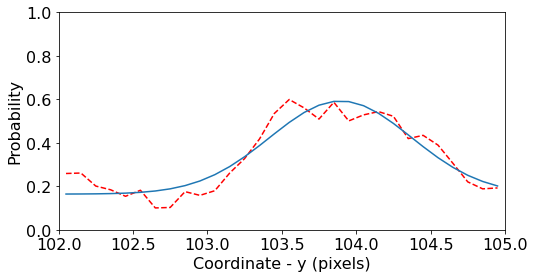

ym = 103.89552981356857 sigma = 0.47750085281606003 amplitude =  0.4282406044809648 shift =  0.1642335219591959


In [951]:
#the first argument is interval, the second - chosen time (start)
ion4.timefold(6, 18)
ion4.Gaussian_fit_y(30,0.5,104.5,0.2)

ym = 103.67636428316891
std error = [0.02205521 0.03142684 0.02305823 0.01669469]


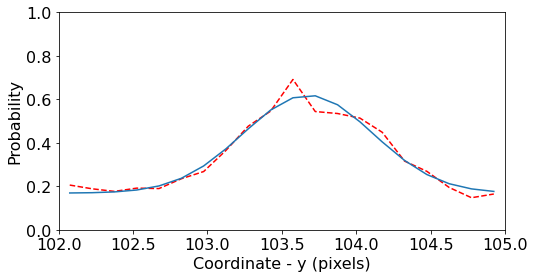

ym = 103.67636428316891 sigma = 0.43792561835707594 amplitude =  0.45024637247943733 shift =  0.16879216860816212


In [952]:
#the first argument is interval, the second - chosen time (start)
ion4.timefold(6, 24)
ion4.Gaussian_fit_y(20,0.5,104.5,0.2)

ym = 103.5011128936482
std error = [0.02912449 0.05534901 0.03265696 0.03169466]


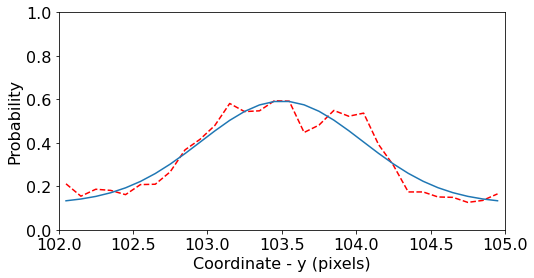

ym = 103.5011128936482 sigma = 0.5440376497699494 amplitude =  -0.4720893760285297 shift =  0.11997366337570461


In [954]:
#the first argument is interval, the second - chosen time (start)
ion4.timefold(6, 30)
ion4.Gaussian_fit_y(30,0.5,104.5,0.2)

ym = 103.43611358897945
std error = [0.05708864 0.12351203 0.06898705 0.07138032]


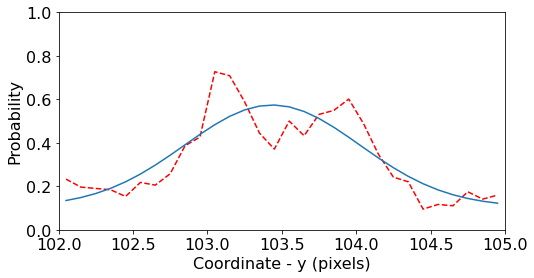

ym = 103.43611358897945 sigma = -0.5889022067689729 amplitude =  -0.4688585334317887 shift =  0.10522159967760474


In [962]:
#the first argument is interval, the second - chosen time (start)
ion4.timefold(6, 36)
ion4.Gaussian_fit_y(30,0.5,104.5,0.2)

ym = 104.29345849713386
std error = [inf inf inf inf]


c:\program files\python38\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


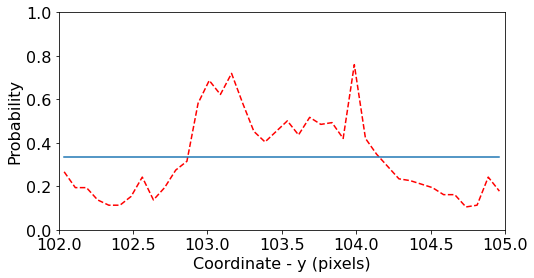

ym = 104.29345849713386 sigma = -0.00019793230152304053 amplitude =  -0.09311731048036147 shift =  0.3333333333267726


In [967]:
#the first argument is interval, the second - chosen time (start)
ion4.timefold(6, 42)
ion4.Gaussian_fit_y(40,0.5,104.5,0.2)

ym = 103.66735463737702
std error = [0.07061084 0.17096925 0.07113753 0.07557571]


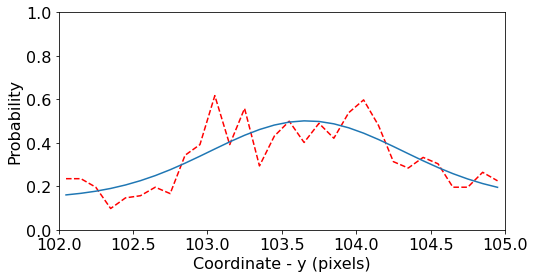

ym = 103.66735463737702 sigma = 0.6505399461016446 amplitude =  0.3569035465816965 shift =  0.14424633902604486


In [961]:
#the first argument is interval, the second - chosen time (start)
ion4.timefold(6, 48)
ion4.Gaussian_fit_y(30,0.5,104.5,0.2)